In [1]:
# Install required packages (run this first)
!pip install nibabel
!pip install SimpleITK
!pip install scikit-image
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install opencv-python
!pip install plotly

# Import all necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage import filters, morphology, measure, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.metrics import jaccard_score, accuracy_score
import cv2
import warnings
warnings.filterwarnings('ignore')

# For better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

  Using cached nibabel-5.3.2-py3-none-any.whl.metadata (9.1 kB)
Using cached nibabel-5.3.2-py3-none-any.whl (3.3 MB)
   ---------------------------------------- 0.0/18.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.8 MB 262.6 kB/s eta 0:01:12
   ---------------------------------------- 0.1/18.8 MB 469.7 kB/s eta 0:00:40
   ---------------------------------------- 0.1/18.8 MB 595.3 kB/s eta 0:00:32
   ---------------------------------------- 0.1/18.8 MB 607.9 kB/s eta 0:00:31
    --------------------------------------- 0.3/18.8 MB 983.0 kB/s eta 0:00:19
    --------------------------------------- 0.4/18.8 MB 1.2 MB/s eta 0:00:16
   - -------------------------------------- 0.5/18.8 MB 1.6 MB/s eta 0:00:12
   -- ------------------------------------- 1.0/18.8 MB 2.5 MB/s eta 0:00:08
   -- ------------------------------------- 1.0/18.8 MB 2.5 MB/s eta 0:00:07
   -- ----------------------------------

In [5]:
# =====================================================================
# CONFIGURE YOUR DATASET PATH HERE
# =====================================================================
# Change this to your actual dataset path
BASE_PATH = r"C:\220902024\wmh_data"  # <-- CHANGE THIS

# Dataset structure
PATHS = {
    'training': os.path.join(BASE_PATH, 'training'),
    'test': os.path.join(BASE_PATH, 'test'),
    'annotations': os.path.join(BASE_PATH, 'additional_annotations')
}

# Cities in the dataset
CITIES = ['Amsterdam', 'Singapore', 'Utrecht']

print("=" * 70)
print("📂 WMH SEGMENTATION CHALLENGE 2017 - DATASET STRUCTURE")
print("=" * 70)

def explore_dataset_structure(base_path):
    """
    Explore and document the WMH Challenge 2017 dataset structure
    """
    dataset_info = {
        'folders': [],
        'cities': [],
        'total_subjects': 0,
        'subjects_per_city': {},
        'file_types': []
    }
    
    if not os.path.exists(base_path):
        print(f"❌ ERROR: Path does not exist: {base_path}")
        print(f"\n📝 Please update BASE_PATH variable with your actual dataset location")
        print(f"   Example: BASE_PATH = '/home/user/datasets/WMH_challenge_2017'")
        return None
    
    for folder_type in ['training', 'test']:
        folder_path = os.path.join(base_path, folder_type)
        if os.path.exists(folder_path):
            dataset_info['folders'].append(folder_type)
            print(f"\n📁 {folder_type.upper()} Folder:")
            
            for city in CITIES:
                city_path = os.path.join(folder_path, city)
                if os.path.exists(city_path):
                    subjects = [d for d in os.listdir(city_path) 
                               if os.path.isdir(os.path.join(city_path, d))]
                    count = len(subjects)
                    
                    key = f"{folder_type}_{city}"
                    dataset_info['subjects_per_city'][key] = count
                    dataset_info['total_subjects'] += count
                    
                    print(f"   └── {city}: {count} subjects")
                    
                    # Check file types in first subject
                    if subjects:
                        first_subject = os.path.join(city_path, subjects[0])
                        files = os.listdir(first_subject)
                        print(f"       Files: {files[:3]}...")  # Show first 3 files
    
    print(f"\n📊 Total subjects across dataset: {dataset_info['total_subjects']}")
    return dataset_info

# Explore the dataset
dataset_info = explore_dataset_structure(BASE_PATH)

# Create metadata DataFrame
metadata_list = []

def create_metadata(base_path):
    """Create metadata DataFrame for all subjects"""
    for folder_type in ['training', 'test']:
        for city in CITIES:
            city_path = os.path.join(base_path, folder_type, city)
            if os.path.exists(city_path):
                subjects = [d for d in os.listdir(city_path) 
                           if os.path.isdir(os.path.join(city_path, d))]
                
                for subject in subjects:
                    subject_path = os.path.join(city_path, subject)
                    files = os.listdir(subject_path)
                    
                    metadata_list.append({
                        'subject_id': subject,
                        'city': city,
                        'dataset': folder_type,
                        'path': subject_path,
                        'n_files': len(files)
                    })
    
    return pd.DataFrame(metadata_list)

if dataset_info:
    metadata_df = create_metadata(BASE_PATH)
    print("\n" + "=" * 70)
    print("📋 METADATA SUMMARY")
    print("=" * 70)
    print(metadata_df.head(10))
    print(f"\nMetadata shape: {metadata_df.shape}")
    print(f"\nDataset distribution:\n{metadata_df.groupby(['dataset', 'city']).size()}")
else:
    print("\n⚠️  Please configure the correct BASE_PATH before proceeding!")

📂 WMH SEGMENTATION CHALLENGE 2017 - DATASET STRUCTURE

📁 TRAINING Folder:
   └── Amsterdam: 1 subjects
       Files: ['100', '101', '102']...
   └── Singapore: 20 subjects
       Files: ['orig', 'pre', 'wmh.nii']...
   └── Utrecht: 20 subjects
       Files: ['orig', 'pre', 'wmh.nii']...

📁 TEST Folder:
   └── Amsterdam: 3 subjects
       Files: ['150', '151', '152']...
   └── Singapore: 30 subjects
       Files: ['orig', 'pre', 'wmh.nii']...
   └── Utrecht: 30 subjects
       Files: ['orig', 'pre', 'wmh.nii']...

📊 Total subjects across dataset: 104

📋 METADATA SUMMARY
  subject_id       city   dataset  \
0       GE3T  Amsterdam  training   
1         50  Singapore  training   
2         51  Singapore  training   
3         52  Singapore  training   
4         53  Singapore  training   
5         54  Singapore  training   
6         55  Singapore  training   
7         56  Singapore  training   
8         57  Singapore  training   
9         58  Singapore  training   

                

In [35]:
# =====================================================================
# IMAGE LOADING AND BASIC UTILITIES
# =====================================================================

def load_nifti(file_path):
    """
    Load NIfTI image and return image data and metadata
    """
    try:
        nii = nib.load(file_path)
        data = nii.get_fdata()
        affine = nii.affine
        header = nii.header
        return data, affine, header
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None, None, None

def save_nifti(data, affine, file_path):
    """
    Save data as NIfTI file
    """
    nii = nib.Nifti1Image(data, affine)
    nib.save(nii, file_path)
    print(f"💾 Saved: {file_path}")

def get_subject_files(subject_path):
    """
    Get FLAIR, T1, and ground truth files for a subject
    
    WMH Challenge 2017 structure:
    - FLAIR: pre/FLAIR.nii.gz or pre/FLAIR.nii
    - T1: pre/T1.nii.gz or orig/T1.nii.gz
    - Ground truth: wmh.nii.gz or wmh.nii
    """
    files = {}
    
    print(f"\n🔍 Searching for files in: {subject_path}")
    
    # Check for FLAIR in multiple locations
    flair_paths = [
        os.path.join(subject_path, 'pre', 'FLAIR.nii.gz'),
        os.path.join(subject_path, 'pre', 'FLAIR.nii'),
        os.path.join(subject_path, 'preprocessed', 'FLAIR.nii.gz'),
        os.path.join(subject_path, 'preprocessed', 'FLAIR.nii'),
        os.path.join(subject_path, 'FLAIR.nii.gz'),
        os.path.join(subject_path, 'FLAIR.nii'),
    ]
    
    for flair_path in flair_paths:
        if os.path.exists(flair_path):
            files['flair'] = flair_path
            print(f"   ✓ Found FLAIR: {os.path.relpath(flair_path, subject_path)}")
            break
    
    # Check for T1 in multiple locations
    t1_paths = [
        os.path.join(subject_path, 'pre', 'T1.nii.gz'),
        os.path.join(subject_path, 'pre', 'T1.nii'),
        os.path.join(subject_path, 'orig', 'T1.nii.gz'),
        os.path.join(subject_path, 'orig', 'T1.nii'),
        os.path.join(subject_path, 'preprocessed', 'T1.nii.gz'),
        os.path.join(subject_path, 'preprocessed', 'T1.nii'),
        os.path.join(subject_path, 'T1.nii.gz'),
        os.path.join(subject_path, 'T1.nii'),
    ]
    
    for t1_path in t1_paths:
        if os.path.exists(t1_path):
            files['t1'] = t1_path
            print(f"   ✓ Found T1: {os.path.relpath(t1_path, subject_path)}")
            break
    
    # Check for ground truth in multiple locations
    gt_paths = [
        os.path.join(subject_path, 'wmh.nii.gz'),
        os.path.join(subject_path, 'wmh.nii'),
        os.path.join(subject_path, 'orig', 'wmh.nii.gz'),
        os.path.join(subject_path, 'orig', 'wmh.nii'),
        os.path.join(subject_path, 'segmentation.nii.gz'),
        os.path.join(subject_path, 'segmentation.nii'),
    ]
    
    for gt_path in gt_paths:
        if os.path.exists(gt_path):
            files['ground_truth'] = gt_path
            print(f"   ✓ Found Ground Truth: {os.path.relpath(gt_path, subject_path)}")
            break
    
    # Print warnings for missing files
    if 'flair' not in files:
        print(f"   ⚠️  WARNING: FLAIR not found!")
        print(f"      Searched in: pre/, preprocessed/, and root directory")
    if 't1' not in files:
        print(f"   ⚠️  INFO: T1 not found (will use FLAIR only for skull stripping)")
    if 'ground_truth' not in files:
        print(f"   ⚠️  INFO: Ground truth not found (evaluation will be skipped)")
    
    return files

def visualize_slice(image, slice_idx=None, title="MRI Slice", cmap='gray', axis=2):
    """
    Visualize a single slice from 3D volume
    """
    if slice_idx is None:
        slice_idx = image.shape[axis] // 2
    
    if axis == 0:
        img_slice = image[slice_idx, :, :]
    elif axis == 1:
        img_slice = image[:, slice_idx, :]
    else:
        img_slice = image[:, :, slice_idx]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_slice.T, cmap=cmap, origin='lower')
    plt.colorbar()
    plt.title(f"{title} - Slice {slice_idx}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_multi_slice(image, num_slices=9, title="MRI Slices", cmap='gray'):
    """
    Visualize multiple slices from 3D volume
    """
    depth = image.shape[2]
    step = depth // (num_slices + 1)
    slices = [step * (i + 1) for i in range(num_slices)]
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    for idx, slice_idx in enumerate(slices):
        axes[idx].imshow(image[:, :, slice_idx].T, cmap=cmap, origin='lower')
        axes[idx].set_title(f'Slice {slice_idx}')
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

print("✅ Image loading utilities defined!")

✅ Image loading utilities defined!


In [37]:
# =====================================================================
# PRE-PROCESSING PIPELINE - PART 1
# =====================================================================

def skull_strip_flair(flair_data, t1_data=None):
    """
    Skull stripping for FLAIR images
    Uses intensity-based thresholding and morphological operations
    
    If T1 is available, it can be used to create a better brain mask
    """
    print("🔪 Performing skull stripping...")
    
    if t1_data is not None:
        # Use T1 for better skull stripping
        print("   Using T1 image for brain mask creation")
        img_sitk = sitk.GetImageFromArray(t1_data.astype(np.float32))
        
        # Otsu thresholding
        otsu_filter = sitk.OtsuThresholdImageFilter()
        otsu_filter.SetInsideValue(0)
        otsu_filter.SetOutsideValue(1)
        mask = otsu_filter.Execute(img_sitk)
        
        # Morphological operations
        mask = sitk.BinaryMorphologicalClosing(mask, [5, 5, 5])
        mask = sitk.BinaryMorphologicalOpening(mask, [3, 3, 3])
        
        # Fill holes
        mask = sitk.BinaryFillhole(mask)
        
        # Convert back to numpy
        brain_mask = sitk.GetArrayFromImage(mask)
    else:
        # Use FLAIR itself for skull stripping
        print("   Using FLAIR image for brain mask creation")
        
        # Normalize
        flair_norm = (flair_data - np.min(flair_data)) / (np.max(flair_data) - np.min(flair_data))
        
        # Otsu thresholding
        threshold = filters.threshold_otsu(flair_norm[flair_norm > 0])
        brain_mask = flair_norm > threshold * 0.3  # Use lower threshold for FLAIR
        
        # Morphological operations
        brain_mask = ndimage.binary_fill_holes(brain_mask)
        brain_mask = morphology.binary_closing(brain_mask, morphology.ball(5))
        brain_mask = morphology.binary_opening(brain_mask, morphology.ball(3))
        
        # Keep largest connected component
        labeled_mask = measure.label(brain_mask)
        regions = measure.regionprops(labeled_mask)
        if regions:
            largest_region = max(regions, key=lambda x: x.area)
            brain_mask = labeled_mask == largest_region.label
    
    # Apply mask to FLAIR
    skull_stripped = flair_data * brain_mask
    
    print(f"   ✓ Brain mask created. Brain voxels: {np.sum(brain_mask):,}")
    
    return skull_stripped, brain_mask


def bias_field_correction(image_data, brain_mask=None):
    """
    N4 Bias Field Correction using SimpleITK
    Corrects for intensity inhomogeneities caused by scanner imperfections
    """
    print("🔧 Performing N4 bias field correction...")
    
    # Convert to SimpleITK image
    image_sitk = sitk.GetImageFromArray(image_data.astype(np.float32))
    
    # Create mask if not provided
    if brain_mask is not None:
        mask_sitk = sitk.GetImageFromArray(brain_mask.astype(np.uint8))
    else:
        # Auto-generate mask
        mask_sitk = sitk.OtsuThreshold(image_sitk, 0, 1, 200)
    
    # N4 Bias Field Correction
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50, 50, 50, 50])
    corrector.SetConvergenceThreshold(0.001)
    
    try:
        corrected_sitk = corrector.Execute(image_sitk, mask_sitk)
        corrected = sitk.GetArrayFromImage(corrected_sitk)
        print("   ✓ Bias field correction completed")
    except Exception as e:
        print(f"   ⚠️ Bias correction failed: {e}. Using original image.")
        corrected = image_data
    
    return corrected


print("✅ Pre-processing Part 1 (Skull Stripping & Bias Correction) defined!")

✅ Pre-processing Part 1 (Skull Stripping & Bias Correction) defined!


In [39]:
# =====================================================================
# PRE-PROCESSING PIPELINE - PART 2
# =====================================================================

def intensity_normalization(image_data, brain_mask=None, method='z-score'):
    """
    Intensity normalization to standardize signal scales across scans
    
    Methods:
    - 'z-score': Zero mean, unit variance
    - 'min-max': Scale to [0, 1]
    - 'percentile': Clip and scale based on percentiles
    - 'nyul': Nyul histogram matching (simplified version)
    """
    print(f"📊 Performing intensity normalization (method: {method})...")
    
    if brain_mask is not None:
        brain_voxels = image_data[brain_mask > 0]
    else:
        brain_voxels = image_data[image_data > 0]
    
    normalized = image_data.copy().astype(np.float32)
    
    if method == 'z-score':
        mean_val = np.mean(brain_voxels)
        std_val = np.std(brain_voxels)
        if std_val > 0:
            normalized = (image_data - mean_val) / std_val
            # Clip extreme values
            normalized = np.clip(normalized, -5, 5)
    
    elif method == 'min-max':
        min_val = np.min(brain_voxels)
        max_val = np.max(brain_voxels)
        if max_val > min_val:
            normalized = (image_data - min_val) / (max_val - min_val)
    
    elif method == 'percentile':
        # Use 1st and 99th percentiles to reduce outlier effect
        p1 = np.percentile(brain_voxels, 1)
        p99 = np.percentile(brain_voxels, 99)
        normalized = np.clip(image_data, p1, p99)
        normalized = (normalized - p1) / (p99 - p1)
    
    elif method == 'nyul':
        # Simplified Nyul normalization
        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        landmarks = np.percentile(brain_voxels, percentiles)
        target_landmarks = np.array([10, 20, 30, 50, 100, 150, 170, 180, 190])
        
        normalized = np.interp(image_data, landmarks, target_landmarks)
    
    print(f"   ✓ Normalization completed. Range: [{np.min(normalized):.2f}, {np.max(normalized):.2f}]")
    
    return normalized


def non_local_means_denoising(image_data, brain_mask=None):
    """
    Non-Local Means denoising
    Reduces noise while preserving edges and details
    """
    print("🔇 Performing Non-Local Means denoising...")
    
    # Estimate noise standard deviation
    if brain_mask is not None:
        sigma_est = estimate_sigma(image_data[brain_mask > 0])
    else:
        sigma_est = estimate_sigma(image_data[image_data > 0])
    
    print(f"   Estimated noise sigma: {sigma_est:.4f}")
    
    # Apply NLM denoising
    denoised = denoise_nl_means(
        image_data,
        h=1.15 * sigma_est,  # Filtering parameter
        fast_mode=True,
        patch_size=5,
        patch_distance=6
    )
    
    print("   ✓ Denoising completed")
    
    return denoised


def gamma_correction(image_data, gamma=1.0, brain_mask=None):
    """
    Gamma correction for contrast enhancement
    
    gamma < 1: Brightens the image
    gamma > 1: Darkens the image
    gamma = 1: No change
    """
    print(f"✨ Applying gamma correction (gamma={gamma})...")
    
    # Normalize to [0, 1]
    if brain_mask is not None:
        brain_voxels = image_data[brain_mask > 0]
        min_val = np.min(brain_voxels)
        max_val = np.max(brain_voxels)
    else:
        min_val = np.min(image_data[image_data > 0])
        max_val = np.max(image_data[image_data > 0])
    
    normalized = np.clip((image_data - min_val) / (max_val - min_val), 0, 1)
    
    # Apply gamma correction
    corrected = np.power(normalized, gamma)
    
    # Scale back
    corrected = corrected * (max_val - min_val) + min_val
    
    print("   ✓ Gamma correction applied")
    
    return corrected


print("✅ Pre-processing Part 2 (Normalization & Denoising) defined!")

✅ Pre-processing Part 2 (Normalization & Denoising) defined!


In [41]:
# =====================================================================
# COMPLETE PRE-PROCESSING PIPELINE
# =====================================================================

def preprocess_flair(flair_data, t1_data=None, save_intermediates=False, output_dir=None):
    """
    Complete preprocessing pipeline for FLAIR images
    
    Steps:
    1. Skull stripping
    2. Bias field correction
    3. Intensity normalization
    4. Non-local means denoising
    5. Gamma correction
    
    Returns:
        preprocessed_data: Fully preprocessed FLAIR image
        brain_mask: Brain mask from skull stripping
        intermediates: Dictionary of intermediate results (if save_intermediates=True)
    """
    print("\n" + "=" * 70)
    print("🔬 STARTING COMPLETE PRE-PROCESSING PIPELINE")
    print("=" * 70)
    
    intermediates = {}
    
    # Step 1: Skull Stripping
    print("\n[1/5] Skull Stripping")
    skull_stripped, brain_mask = skull_strip_flair(flair_data, t1_data)
    if save_intermediates:
        intermediates['01_skull_stripped'] = skull_stripped
        intermediates['brain_mask'] = brain_mask
    
    # Step 2: Bias Field Correction
    print("\n[2/5] Bias Field Correction")
    bias_corrected = bias_field_correction(skull_stripped, brain_mask)
    if save_intermediates:
        intermediates['02_bias_corrected'] = bias_corrected
    
    # Step 3: Intensity Normalization
    print("\n[3/5] Intensity Normalization")
    normalized = intensity_normalization(bias_corrected, brain_mask, method='percentile')
    if save_intermediates:
        intermediates['03_normalized'] = normalized
    
    # Step 4: Non-Local Means Denoising
    print("\n[4/5] Non-Local Means Denoising")
    denoised = non_local_means_denoising(normalized, brain_mask)
    if save_intermediates:
        intermediates['04_denoised'] = denoised
    
    # Step 5: Gamma Correction
    print("\n[5/5] Gamma Correction")
    gamma_corrected = gamma_correction(denoised, gamma=0.9, brain_mask=brain_mask)
    if save_intermediates:
        intermediates['05_gamma_corrected'] = gamma_corrected
    
    preprocessed_data = gamma_corrected
    
    print("\n" + "=" * 70)
    print("✅ PRE-PROCESSING PIPELINE COMPLETED!")
    print("=" * 70)
    
    return preprocessed_data, brain_mask, intermediates


def visualize_preprocessing_steps(original, intermediates, slice_idx=None):
    """
    Visualize all preprocessing steps
    """
    if slice_idx is None:
        slice_idx = original.shape[2] // 2
    
    steps = ['Original'] + list(intermediates.keys())
    images = [original] + list(intermediates.values())
    
    n_steps = len(steps)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, (step_name, img) in enumerate(zip(steps[:6], images[:6])):
        if 'mask' in step_name.lower():
            axes[idx].imshow(img[:, :, slice_idx].T, cmap='gray', origin='lower')
        else:
            axes[idx].imshow(img[:, :, slice_idx].T, cmap='gray', origin='lower')
        axes[idx].set_title(step_name.replace('_', ' ').title())
        axes[idx].axis('off')
    
    plt.suptitle(f'Pre-processing Steps - Slice {slice_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()


print("✅ Complete pre-processing pipeline defined!")

✅ Complete pre-processing pipeline defined!


In [43]:
# =====================================================================
# SEGMENTATION PIPELINE - WMH DETECTION
# =====================================================================

def intensity_based_segmentation(preprocessed_flair, brain_mask, method='otsu'):
    """
    Intensity-based segmentation for WMH detection
    
    Methods:
    - 'otsu': Otsu thresholding
    - 'adaptive': Adaptive thresholding
    - 'percentile': Percentile-based thresholding
    - 'combined': Multi-level thresholding
    """
    print(f"🎯 Performing intensity-based segmentation (method: {method})...")
    
    # Work only with brain voxels
    brain_voxels = preprocessed_flair[brain_mask > 0]
    
    if method == 'otsu':
        # Otsu thresholding
        threshold = filters.threshold_otsu(brain_voxels)
        print(f"   Otsu threshold: {threshold:.4f}")
        initial_seg = (preprocessed_flair > threshold) & (brain_mask > 0)
    
    elif method == 'adaptive':
        # Use higher percentile for WMH (bright regions)
        threshold = np.percentile(brain_voxels, 85)
        print(f"   Adaptive threshold (85th percentile): {threshold:.4f}")
        initial_seg = (preprocessed_flair > threshold) & (brain_mask > 0)
    
    elif method == 'percentile':
        # More aggressive thresholding for WMH
        threshold = np.percentile(brain_voxels, 90)
        print(f"   Percentile threshold (90th): {threshold:.4f}")
        initial_seg = (preprocessed_flair > threshold) & (brain_mask > 0)
    
    elif method == 'combined':
        # Combined approach: Otsu + percentile
        otsu_thresh = filters.threshold_otsu(brain_voxels)
        perc_thresh = np.percentile(brain_voxels, 88)
        threshold = max(otsu_thresh, perc_thresh)
        print(f"   Combined threshold: {threshold:.4f}")
        initial_seg = (preprocessed_flair > threshold) & (brain_mask > 0)
    
    print(f"   ✓ Initial segmentation: {np.sum(initial_seg):,} voxels")
    
    return initial_seg.astype(np.uint8)


def morphological_filtering_3d(segmentation, brain_mask):
    """
    3D morphological filtering to refine segmentation
    - Remove small isolated voxels (noise)
    - Fill small holes
    - Smooth boundaries
    """
    print("🔮 Applying 3D morphological filtering...")
    
    # Binary opening to remove small objects
    print("   - Opening (remove small noise)...")
    opened = morphology.binary_opening(segmentation, morphology.ball(2))
    
    # Binary closing to fill small holes
    print("   - Closing (fill small holes)...")
    closed = morphology.binary_closing(opened, morphology.ball(2))
    
    # Remove very small connected components
    print("   - Removing tiny components...")
    labeled = measure.label(closed)
    regions = measure.regionprops(labeled)
    
    # Keep only components larger than minimum size (e.g., 10 voxels)
    min_size = 10
    filtered = np.zeros_like(closed)
    for region in regions:
        if region.area >= min_size:
            filtered[labeled == region.label] = 1
    
    # Ensure within brain mask
    filtered = filtered & brain_mask
    
    print(f"   ✓ Morphological filtering completed")
    print(f"   Regions before: {len(regions)}, After: {np.sum([r.area >= min_size for r in regions])}")
    
    return filtered.astype(np.uint8)


def remove_false_positives(segmentation, brain_mask, preprocessed_flair):
    """
    Post-processing to remove false positives
    - Remove regions that are too large (likely not WMH)
    - Remove regions with unusual shape
    - Refine based on intensity characteristics
    """
    print("🧹 Removing false positives...")
    
    labeled = measure.label(segmentation)
    regions = measure.regionprops(labeled, intensity_image=preprocessed_flair)
    
    cleaned = np.zeros_like(segmentation)
    removed_count = 0
    
    for region in regions:
        # Rule 1: Size constraints
        # WMH typically range from small spots to ~5000 voxels
        # Extremely large regions are likely artifacts
        if region.area > 10000:
            removed_count += 1
            continue
        
        # Rule 2: Sphericity/solidity check
        # WMH should have reasonable shape (not too elongated)
        if region.solidity < 0.3:  # Too irregular
            removed_count += 1
            continue
        
        # Rule 3: Intensity check
        # Mean intensity should be high (bright on FLAIR)
        mean_intensity = region.mean_intensity
        brain_mean = np.mean(preprocessed_flair[brain_mask > 0])
        
        if mean_intensity < brain_mean * 1.2:  # Should be brighter than average brain
            removed_count += 1
            continue
        
        # Keep this region
        cleaned[labeled == region.label] = 1
    
    print(f"   ✓ Removed {removed_count} false positive regions")
    print(f"   Remaining regions: {len(regions) - removed_count}")
    
    return cleaned.astype(np.uint8)


def segment_wmh(preprocessed_flair, brain_mask):
    """
    Complete WMH segmentation pipeline
    
    Steps:
    1. Intensity-based segmentation
    2. 3D morphological filtering
    3. False positive removal
    
    Returns:
        wmh_mask: Binary mask of detected WMHs
    """
    print("\n" + "=" * 70)
    print("🎯 STARTING WMH SEGMENTATION PIPELINE")
    print("=" * 70)
    
    # Step 1: Intensity-based segmentation
    print("\n[1/3] Intensity-based Segmentation")
    initial_seg = intensity_based_segmentation(preprocessed_flair, brain_mask, method='combined')
    
    # Step 2: Morphological filtering
    print("\n[2/3] 3D Morphological Filtering")
    morpho_filtered = morphological_filtering_3d(initial_seg, brain_mask)
    
    # Step 3: Remove false positives
    print("\n[3/3] False Positive Removal")
    wmh_mask = remove_false_positives(morpho_filtered, brain_mask, preprocessed_flair)
    
    total_wmh_volume = np.sum(wmh_mask)
    print("\n" + "=" * 70)
    print(f"✅ WMH SEGMENTATION COMPLETED!")
    print(f"   Total WMH voxels: {total_wmh_volume:,}")
    print("=" * 70)
    
    return wmh_mask


print("✅ WMH segmentation pipeline defined!")

✅ WMH segmentation pipeline defined!


In [45]:
# =====================================================================
# LABELING: PERIVENTRICULAR vs DEEP WMH
# =====================================================================

def detect_ventricles(preprocessed_flair, brain_mask):
    """
    Detect lateral ventricles in FLAIR image
    Ventricles appear dark (CSF suppressed) in FLAIR
    """
    print("🧠 Detecting ventricles...")
    
    # Ventricles are very dark regions within the brain
    brain_voxels = preprocessed_flair[brain_mask > 0]
    
    # Use low percentile for dark regions
    threshold = np.percentile(brain_voxels, 5)
    ventricle_mask = (preprocessed_flair < threshold) & (brain_mask > 0)
    
    # Morphological operations to clean up
    ventricle_mask = morphology.binary_closing(ventricle_mask, morphology.ball(3))
    ventricle_mask = morphology.binary_opening(ventricle_mask, morphology.ball(2))
    
    # Keep only central regions (ventricles are central)
    labeled_ventricles = measure.label(ventricle_mask)
    regions = measure.regionprops(labeled_ventricles)
    
    # Filter by size and location
    cleaned_ventricles = np.zeros_like(ventricle_mask)
    center = np.array(ventricle_mask.shape) // 2
    
    for region in regions:
        # Ventricles should be reasonably sized
        if 100 < region.area < 5000:
            # And relatively central
            centroid = np.array(region.centroid)
            dist_from_center = np.linalg.norm(centroid - center)
            
            if dist_from_center < min(ventricle_mask.shape) * 0.3:
                cleaned_ventricles[labeled_ventricles == region.label] = 1
    
    print(f"   ✓ Ventricles detected: {np.sum(cleaned_ventricles):,} voxels")
    
    return cleaned_ventricles.astype(np.uint8)


def compute_distance_from_ventricles(ventricle_mask):
    """
    Compute Euclidean distance transform from ventricles
    """
    print("📏 Computing distance from ventricles...")
    
    # Distance transform
    distance_map = ndimage.distance_transform_edt(1 - ventricle_mask)
    
    print(f"   ✓ Distance map computed. Max distance: {np.max(distance_map):.2f} voxels")
    
    return distance_map


def label_periventricular_deep(wmh_mask, ventricle_mask, distance_threshold=10):
    """
    Label WMHs as periventricular or deep based on distance from ventricles
    
    Periventricular: Within distance_threshold from ventricles
    Deep: Beyond distance_threshold from ventricles
    
    Args:
        wmh_mask: Binary mask of WMHs
        ventricle_mask: Binary mask of ventricles
        distance_threshold: Distance in voxels (typically 10mm ~ 10 voxels for 1mm resolution)
    
    Returns:
        periventricular_mask: Binary mask of periventricular WMHs
        deep_mask: Binary mask of deep WMHs
        labeled_mask: Combined mask (1=periventricular, 2=deep)
    """
    print(f"\n🏷️  Labeling WMHs (distance threshold: {distance_threshold} voxels)...")
    
    # Compute distance from ventricles
    distance_map = compute_distance_from_ventricles(ventricle_mask)
    
    # Label based on distance
    periventricular_mask = (wmh_mask > 0) & (distance_map <= distance_threshold)
    deep_mask = (wmh_mask > 0) & (distance_map > distance_threshold)
    
    # Create combined labeled mask
    labeled_mask = np.zeros_like(wmh_mask)
    labeled_mask[periventricular_mask] = 1
    labeled_mask[deep_mask] = 2
    
    # Count lesions in each category
    pv_regions = measure.label(periventricular_mask)
    deep_regions = measure.label(deep_mask)
    
    n_pv = len(np.unique(pv_regions)) - 1  # Subtract background
    n_deep = len(np.unique(deep_regions)) - 1
    
    pv_volume = np.sum(periventricular_mask)
    deep_volume = np.sum(deep_mask)
    
    print(f"\n   📊 Labeling Results:")
    print(f"   Periventricular WMHs: {n_pv} lesions, {pv_volume:,} voxels")
    print(f"   Deep WMHs: {n_deep} lesions, {deep_volume:,} voxels")
    
    return periventricular_mask.astype(np.uint8), deep_mask.astype(np.uint8), labeled_mask


print("✅ WMH labeling functions defined!")

✅ WMH labeling functions defined!


In [69]:
# =====================================================================
# FEATURE EXTRACTION
# =====================================================================

def extract_wmh_features(wmh_mask, periventricular_mask, deep_mask, voxel_spacing=(1.0, 1.0, 1.0)):
    """
    Extract comprehensive features from WMH segmentation
    
    Features extracted:
    - Lesion count (total, periventricular, deep)
    - Total volume (in mm³)
    - Largest lesion size (diameter and volume)
    - Spatial distribution metrics
    - Lesion load percentage
    
    Args:
        wmh_mask: Binary mask of all WMHs
        periventricular_mask: Binary mask of periventricular WMHs
        deep_mask: Binary mask of deep WMHs
        voxel_spacing: Voxel dimensions in mm (default: 1mm isotropic)
    
    Returns:
        features: Dictionary of extracted features
    """
    print("\n" + "=" * 70)
    print("📊 EXTRACTING WMH FEATURES")
    print("=" * 70)
    
    features = {}
    
    # Voxel volume in mm³
    voxel_volume = np.prod(voxel_spacing)
    
    # === 1. LESION COUNT ===
    print("\n[1/5] Lesion Count")
    
    total_labeled = measure.label(wmh_mask)
    pv_labeled = measure.label(periventricular_mask)
    deep_labeled = measure.label(deep_mask)
    
    features['total_lesion_count'] = len(np.unique(total_labeled)) - 1
    features['periventricular_count'] = len(np.unique(pv_labeled)) - 1
    features['deep_count'] = len(np.unique(deep_labeled)) - 1
    
    print(f"   Total lesions: {features['total_lesion_count']}")
    print(f"   Periventricular: {features['periventricular_count']}")
    print(f"   Deep: {features['deep_count']}")
    
    # === 2. TOTAL VOLUME ===
    print("\n[2/5] Total Volume")
    
    features['total_wmh_volume_voxels'] = np.sum(wmh_mask)
    features['total_wmh_volume_mm3'] = features['total_wmh_volume_voxels'] * voxel_volume
    features['periventricular_volume_mm3'] = np.sum(periventricular_mask) * voxel_volume
    features['deep_volume_mm3'] = np.sum(deep_mask) * voxel_volume
    
    print(f"   Total WMH volume: {features['total_wmh_volume_mm3']:.2f} mm³")
    print(f"   Periventricular: {features['periventricular_volume_mm3']:.2f} mm³")
    print(f"   Deep: {features['deep_volume_mm3']:.2f} mm³")
    
    # === 3. LARGEST LESION ===
    print("\n[3/5] Largest Lesion Characteristics")
    
    total_regions = measure.regionprops(total_labeled)
    
    if total_regions:
        largest_region = max(total_regions, key=lambda x: x.area)
        
        features['largest_lesion_volume_mm3'] = largest_region.area * voxel_volume
        
        # Estimate diameter (assuming spherical)
        radius = (3 * largest_region.area / (4 * np.pi)) ** (1/3)
        features['largest_lesion_diameter_mm'] = 2 * radius * voxel_spacing[0]
        
        # Bounding box dimensions
        bbox = largest_region.bbox
        dimensions = np.array([
            bbox[3] - bbox[0],
            bbox[4] - bbox[1],
            bbox[5] - bbox[2]
        ]) * np.array(voxel_spacing)
        
        features['largest_lesion_dim_x_mm'] = dimensions[0]
        features['largest_lesion_dim_y_mm'] = dimensions[1]
        features['largest_lesion_dim_z_mm'] = dimensions[2]
        
        print(f"   Largest lesion volume: {features['largest_lesion_volume_mm3']:.2f} mm³")
        print(f"   Estimated diameter: {features['largest_lesion_diameter_mm']:.2f} mm")
        print(f"   Dimensions (x,y,z): ({dimensions[0]:.1f}, {dimensions[1]:.1f}, {dimensions[2]:.1f}) mm")
    else:
        features['largest_lesion_volume_mm3'] = 0
        features['largest_lesion_diameter_mm'] = 0
        features['largest_lesion_dim_x_mm'] = 0
        features['largest_lesion_dim_y_mm'] = 0
        features['largest_lesion_dim_z_mm'] = 0
        print("   No lesions detected")
    
    # === 4. SPATIAL DISTRIBUTION ===
    print("\n[4/5] Spatial Distribution")
    
    if total_regions:
        # Center of mass for all WMHs
        com = ndimage.center_of_mass(wmh_mask)
        features['center_of_mass_x'] = com[0]
        features['center_of_mass_y'] = com[1]
        features['center_of_mass_z'] = com[2]
        
        # Spread/dispersion
        centroids = np.array([region.centroid for region in total_regions])
        
        if len(centroids) > 1:
            # Compute pairwise distances
            distances = cdist(centroids, centroids)
            features['mean_inter_lesion_distance'] = np.mean(distances[np.triu_indices_from(distances, k=1)])
            features['max_inter_lesion_distance'] = np.max(distances)
        else:
            features['mean_inter_lesion_distance'] = 0
            features['max_inter_lesion_distance'] = 0
        
        # Hemisphere distribution (left vs right)
        midline = wmh_mask.shape[0] // 2
        left_hemisphere = np.sum(wmh_mask[:midline, :, :])
        right_hemisphere = np.sum(wmh_mask[midline:, :, :])
        
        features['left_hemisphere_volume_mm3'] = left_hemisphere * voxel_volume
        features['right_hemisphere_volume_mm3'] = right_hemisphere * voxel_volume
        
        if left_hemisphere + right_hemisphere > 0:
            features['asymmetry_index'] = abs(left_hemisphere - right_hemisphere) / (left_hemisphere + right_hemisphere)
        else:
            features['asymmetry_index'] = 0
        
        print(f"   Center of mass: ({com[0]:.1f}, {com[1]:.1f}, {com[2]:.1f})")
        print(f"   Mean inter-lesion distance: {features['mean_inter_lesion_distance']:.2f} voxels")
        print(f"   Asymmetry index: {features['asymmetry_index']:.3f}")
    else:
        features['center_of_mass_x'] = 0
        features['center_of_mass_y'] = 0
        features['center_of_mass_z'] = 0
        features['mean_inter_lesion_distance'] = 0
        features['max_inter_lesion_distance'] = 0
        features['left_hemisphere_volume_mm3'] = 0
        features['right_hemisphere_volume_mm3'] = 0
        features['asymmetry_index'] = 0
    
    # === 5. ADDITIONAL METRICS ===
    print("\n[5/5] Additional Metrics")
    
    if total_regions:
        # Average lesion size
        lesion_sizes = [region.area * voxel_volume for region in total_regions]
        features['mean_lesion_volume_mm3'] = np.mean(lesion_sizes)
        features['median_lesion_volume_mm3'] = np.median(lesion_sizes)
        features['std_lesion_volume_mm3'] = np.std(lesion_sizes)
        
        # Shape metrics - solidity works in 3D
        solidities = [region.solidity for region in total_regions]
        features['mean_lesion_solidity'] = np.mean(solidities)
        
        # Extent (also works in 3D)
        extents = [region.extent for region in total_regions]
        features['mean_lesion_extent'] = np.mean(extents)
        
        print(f"   Mean lesion volume: {features['mean_lesion_volume_mm3']:.2f} mm³")
        print(f"   Median lesion volume: {features['median_lesion_volume_mm3']:.2f} mm³")
        print(f"   Mean solidity: {features['mean_lesion_solidity']:.3f}")
        print(f"   Mean extent: {features['mean_lesion_extent']:.3f}")
    else:
        features['mean_lesion_volume_mm3'] = 0
        features['median_lesion_volume_mm3'] = 0
        features['std_lesion_volume_mm3'] = 0
        features['mean_lesion_solidity'] = 0
        features['mean_lesion_extent'] = 0
    
    print("\n" + "=" * 70)
    print("✅ FEATURE EXTRACTION COMPLETED!")
    print("=" * 70)
    
    return features


def features_to_dataframe(features):
    """Convert features dictionary to pandas DataFrame"""
    return pd.DataFrame([features])


print("✅ Feature extraction functions defined!")

✅ Feature extraction functions defined!


In [71]:
# =====================================================================
# CLASSIFICATION: RULE-BASED WMH BURDEN CATEGORIZATION
# =====================================================================

def classify_wmh_burden(features, method='fazekas'):
    """
    Classify WMH burden as Mild, Moderate, or Severe
    
    Methods:
    - 'fazekas': Based on Fazekas scale (clinical standard)
    - 'volume': Based on total WMH volume
    - 'count': Based on lesion count
    - 'combined': Combination of multiple criteria
    
    Fazekas Scale:
    - Grade 0: No WMH
    - Grade 1 (Mild): Pencil-thin lining or caps
    - Grade 2 (Moderate): Smooth halo
    - Grade 3 (Severe): Large confluent areas
    
    Returns:
        classification: 'Mild', 'Moderate', or 'Severe'
        confidence: Confidence score
        explanation: Reasoning for classification
    """
    print("\n" + "=" * 70)
    print("🎓 CLASSIFYING WMH BURDEN")
    print("=" * 70)
    
    total_volume = features['total_wmh_volume_mm3']
    total_count = features['total_lesion_count']
    largest_volume = features['largest_lesion_volume_mm3']
    pv_volume = features['periventricular_volume_mm3']
    deep_volume = features['deep_volume_mm3']
    
    classification = "Mild"
    confidence = 0.0
    explanation = []
    
    if method == 'fazekas':
        print("\n📋 Using Fazekas-inspired scale...")
        
        # Periventricular WMH scoring
        pv_score = 0
        if pv_volume < 500:
            pv_score = 1
            explanation.append(f"PV volume {pv_volume:.0f}mm³ < 500mm³ → PV score 1")
        elif pv_volume < 2000:
            pv_score = 2
            explanation.append(f"PV volume {pv_volume:.0f}mm³ < 2000mm³ → PV score 2")
        else:
            pv_score = 3
            explanation.append(f"PV volume {pv_volume:.0f}mm³ ≥ 2000mm³ → PV score 3")
        
        # Deep WMH scoring
        deep_score = 0
        if deep_volume < 1000:
            deep_score = 1
            explanation.append(f"Deep volume {deep_volume:.0f}mm³ < 1000mm³ → Deep score 1")
        elif deep_volume < 3000:
            deep_score = 2
            explanation.append(f"Deep volume {deep_volume:.0f}mm³ < 3000mm³ → Deep score 2")
        else:
            deep_score = 3
            explanation.append(f"Deep volume {deep_volume:.0f}mm³ ≥ 3000mm³ → Deep score 3")
        
        # Combined score
        combined_score = max(pv_score, deep_score)
        
        if combined_score == 1:
            classification = "Mild"
            confidence = 0.8
        elif combined_score == 2:
            classification = "Moderate"
            confidence = 0.8
        else:
            classification = "Severe"
            confidence = 0.8
        
        explanation.append(f"Max(PV score, Deep score) = {combined_score} → {classification}")
    
    elif method == 'volume':
        print("\n📏 Using volume-based classification...")
        
        if total_volume < 1000:
            classification = "Mild"
            confidence = 0.75
            explanation.append(f"Total volume {total_volume:.0f}mm³ < 1000mm³")
        elif total_volume < 5000:
            classification = "Moderate"
            confidence = 0.75
            explanation.append(f"Total volume {total_volume:.0f}mm³ < 5000mm³")
        else:
            classification = "Severe"
            confidence = 0.75
            explanation.append(f"Total volume {total_volume:.0f}mm³ ≥ 5000mm³")
    
    elif method == 'count':
        print("\n🔢 Using count-based classification...")
        
        if total_count < 5:
            classification = "Mild"
            confidence = 0.7
            explanation.append(f"Lesion count {total_count} < 5")
        elif total_count < 15:
            classification = "Moderate"
            confidence = 0.7
            explanation.append(f"Lesion count {total_count} < 15")
        else:
            classification = "Severe"
            confidence = 0.7
            explanation.append(f"Lesion count {total_count} ≥ 15")
    
    elif method == 'combined':
        print("\n🔄 Using combined classification...")
        
        scores = []
        
        # Volume criterion
        if total_volume < 1000:
            scores.append(1)
        elif total_volume < 5000:
            scores.append(2)
        else:
            scores.append(3)
        
        # Count criterion
        if total_count < 5:
            scores.append(1)
        elif total_count < 15:
            scores.append(2)
        else:
            scores.append(3)
        
        # Largest lesion criterion
        if largest_volume < 500:
            scores.append(1)
        elif largest_volume < 2000:
            scores.append(2)
        else:
            scores.append(3)
        
        # Average score
        avg_score = np.mean(scores)
        
        if avg_score < 1.7:
            classification = "Mild"
            confidence = 0.85
        elif avg_score < 2.4:
            classification = "Moderate"
            confidence = 0.85
        else:
            classification = "Severe"
            confidence = 0.85
        
        explanation.append(f"Volume criterion score: {scores[0]}")
        explanation.append(f"Count criterion score: {scores[1]}")
        explanation.append(f"Largest lesion score: {scores[2]}")
        explanation.append(f"Average score: {avg_score:.2f} → {classification}")
    
    print(f"\n🎯 Classification: {classification}")
    print(f"   Confidence: {confidence:.2%}")
    print(f"\n📝 Explanation:")
    for exp in explanation:
        print(f"   - {exp}")
    
    print("=" * 70)
    
    return {
        'classification': classification,
        'confidence': confidence,
        'explanation': explanation,
        'method': method
    }


def generate_clinical_report(features, classification_result):
    """
    Generate a clinical-style report
    """
    report = []
    report.append("=" * 70)
    report.append("AUTOMATED WMH BURDEN ASSESSMENT REPORT")
    report.append("=" * 70)
    report.append("")
    
    report.append("QUANTITATIVE MEASUREMENTS:")
    report.append(f"  • Total WMH Volume: {features['total_wmh_volume_mm3']:.2f} mm³")
    report.append(f"  • Total Lesion Count: {features['total_lesion_count']}")
    report.append(f"  • Periventricular WMHs: {features['periventricular_count']} lesions, {features['periventricular_volume_mm3']:.2f} mm³")
    report.append(f"  • Deep WMHs: {features['deep_count']} lesions, {features['deep_volume_mm3']:.2f} mm³")
    report.append("")
    
    report.append("LARGEST LESION:")
    report.append(f"  • Volume: {features['largest_lesion_volume_mm3']:.2f} mm³")
    report.append(f"  • Estimated Diameter: {features['largest_lesion_diameter_mm']:.2f} mm")
    report.append("")
    
    report.append("SPATIAL DISTRIBUTION:")
    report.append(f"  • Left Hemisphere: {features['left_hemisphere_volume_mm3']:.2f} mm³")
    report.append(f"  • Right Hemisphere: {features['right_hemisphere_volume_mm3']:.2f} mm³")
    report.append(f"  • Asymmetry Index: {features['asymmetry_index']:.3f}")
    report.append("")
    
    report.append("CLASSIFICATION:")
    report.append(f"  • WMH Burden: {classification_result['classification'].upper()}")
    report.append(f"  • Confidence: {classification_result['confidence']:.1%}")
    report.append(f"  • Method: {classification_result['method']}")
    report.append("")
    
    report.append("=" * 70)
    
    return "\n".join(report)


print("✅ Classification functions defined!")

✅ Classification functions defined!


In [73]:
# =====================================================================
# PERFORMANCE EVALUATION METRICS
# =====================================================================

def dice_coefficient(pred, true):
    """
    Compute Dice Similarity Coefficient
    DSC = 2 * |A ∩ B| / (|A| + |B|)
    """
    pred = pred.astype(bool)
    true = true.astype(bool)
    
    intersection = np.logical_and(pred, true).sum()
    
    if pred.sum() + true.sum() == 0:
        return 1.0  # Both empty
    
    dice = 2.0 * intersection / (pred.sum() + true.sum())
    return dice


def jaccard_index(pred, true):
    """
    Compute Jaccard Index (IoU)
    IoU = |A ∩ B| / |A ∪ B|
    """
    pred = pred.astype(bool)
    true = true.astype(bool)
    
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    
    if union == 0:
        return 1.0  # Both empty
    
    jaccard = intersection / union
    return jaccard


def compute_ssim_3d(pred, true, win_size=7):
    """
    Compute Structural Similarity Index (SSIM) for 3D volumes
    Average SSIM across all slices
    """
    from skimage.metrics import structural_similarity as ssim
    
    ssim_scores = []
    
    # Compute SSIM for each axial slice
    for i in range(pred.shape[2]):
        pred_slice = pred[:, :, i]
        true_slice = true[:, :, i]
        
        if pred_slice.max() > 0 or true_slice.max() > 0:
            # Normalize slices
            pred_norm = (pred_slice - pred_slice.min()) / (pred_slice.max() - pred_slice.min() + 1e-8)
            true_norm = (true_slice - true_slice.min()) / (true_slice.max() - true_slice.min() + 1e-8)
            
            score = ssim(true_norm, pred_norm, data_range=1.0)
            ssim_scores.append(score)
    
    return np.mean(ssim_scores) if ssim_scores else 0.0


def sensitivity_specificity(pred, true):
    """
    Compute Sensitivity (Recall) and Specificity
    
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    """
    pred = pred.astype(bool).flatten()
    true = true.astype(bool).flatten()
    
    TP = np.logical_and(pred, true).sum()
    TN = np.logical_and(~pred, ~true).sum()
    FP = np.logical_and(pred, ~true).sum()
    FN = np.logical_and(~pred, true).sum()
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    
    return sensitivity, specificity


def volumetric_similarity(pred, true):
    """
    Compute volumetric similarity
    VS = 1 - |V_pred - V_true| / (V_pred + V_true)
    """
    v_pred = pred.sum()
    v_true = true.sum()
    
    if v_pred + v_true == 0:
        return 1.0
    
    vs = 1.0 - abs(v_pred - v_true) / (v_pred + v_true)
    return vs


def evaluate_segmentation(predicted_mask, ground_truth_mask):
    """
    Comprehensive evaluation of segmentation performance
    
    Metrics:
    - Dice Coefficient
    - Jaccard Index
    - Sensitivity & Specificity
    - Volumetric Similarity
    - SSIM
    """
    print("\n" + "=" * 70)
    print("📊 SEGMENTATION PERFORMANCE EVALUATION")
    print("=" * 70)
    
    metrics = {}
    
    print("\nComputing metrics...")
    
    # Dice Coefficient
    metrics['dice'] = dice_coefficient(predicted_mask, ground_truth_mask)
    print(f"  ✓ Dice Coefficient: {metrics['dice']:.4f}")
    
    # Jaccard Index
    metrics['jaccard'] = jaccard_index(predicted_mask, ground_truth_mask)
    print(f"  ✓ Jaccard Index: {metrics['jaccard']:.4f}")
    
    # Sensitivity & Specificity
    sensitivity, specificity = sensitivity_specificity(predicted_mask, ground_truth_mask)
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    print(f"  ✓ Sensitivity: {sensitivity:.4f}")
    print(f"  ✓ Specificity: {specificity:.4f}")
    
    # Volumetric Similarity
    metrics['volumetric_similarity'] = volumetric_similarity(predicted_mask, ground_truth_mask)
    print(f"  ✓ Volumetric Similarity: {metrics['volumetric_similarity']:.4f}")
    
    # SSIM
    print("  ⏳ Computing SSIM (this may take a moment)...")
    metrics['ssim'] = compute_ssim_3d(predicted_mask.astype(float), ground_truth_mask.astype(float))
    print(f"  ✓ SSIM: {metrics['ssim']:.4f}")
    
    # Volume metrics
    pred_volume = predicted_mask.sum()
    true_volume = ground_truth_mask.sum()
    metrics['predicted_volume'] = pred_volume
    metrics['true_volume'] = true_volume
    metrics['volume_difference'] = pred_volume - true_volume
    metrics['volume_difference_percent'] = (pred_volume - true_volume) / true_volume * 100 if true_volume > 0 else 0
    
    print(f"\n  📏 Volume Comparison:")
    print(f"     Predicted: {pred_volume:,} voxels")
    print(f"     Ground Truth: {true_volume:,} voxels")
    print(f"     Difference: {metrics['volume_difference_percent']:.2f}%")
    
    print("\n" + "=" * 70)
    print("✅ EVALUATION COMPLETED!")
    print("=" * 70)
    
    return metrics


print("✅ Evaluation metrics defined!")

✅ Evaluation metrics defined!


In [75]:
# =====================================================================
# VISUALIZATION FUNCTIONS
# =====================================================================

def visualize_segmentation_overlay(original, segmentation, slice_idx=None, title="WMH Segmentation"):
    """
    Overlay segmentation on original image
    """
    if slice_idx is None:
        slice_idx = original.shape[2] // 2
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original
    axes[0].imshow(original[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0].set_title('Original FLAIR')
    axes[0].axis('off')
    
    # Segmentation
    axes[1].imshow(segmentation[:, :, slice_idx].T, cmap='hot', origin='lower')
    axes[1].set_title('WMH Segmentation')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(original[:, :, slice_idx].T, cmap='gray', origin='lower', alpha=1.0)
    axes[2].imshow(segmentation[:, :, slice_idx].T, cmap='hot', origin='lower', alpha=0.5)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.suptitle(f'{title} - Slice {slice_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()


def visualize_pv_deep_labels(original, periventricular, deep, slice_idx=None):
    """
    Visualize periventricular vs deep WMH labels
    """
    if slice_idx is None:
        slice_idx = original.shape[2] // 2
    
    # Create combined RGB visualization
    combined = np.zeros((*original.shape[:2], 3))
    
    # Red channel: Periventricular
    combined[:, :, 0] = periventricular[:, :, slice_idx]
    
    # Green channel: Deep
    combined[:, :, 1] = deep[:, :, slice_idx]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original
    axes[0].imshow(original[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[0].set_title('Original FLAIR')
    axes[0].axis('off')
    
    # Separate labels
    axes[1].imshow(periventricular[:, :, slice_idx].T, cmap='Reds', origin='lower', alpha=1.0)
    axes[1].imshow(deep[:, :, slice_idx].T, cmap='Greens', origin='lower', alpha=0.7)
    axes[1].set_title('PV (Red) vs Deep (Green)')
    axes[1].axis('off')
    
    # Overlay on original
    axes[2].imshow(original[:, :, slice_idx].T, cmap='gray', origin='lower')
    axes[2].imshow(combined.transpose(1, 0, 2), alpha=0.5, origin='lower')
    axes[2].set_title('Labeled Overlay')
    axes[2].axis('off')
    
    plt.suptitle(f'Periventricular vs Deep WMH - Slice {slice_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_feature_summary(features):
    """
    Create comprehensive feature visualization
    """
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Volume comparison
    ax1 = fig.add_subplot(gs[0, 0])
    volumes = [features['periventricular_volume_mm3'], features['deep_volume_mm3']]
    colors = ['#e74c3c', '#2ecc71']
    ax1.bar(['Periventricular', 'Deep'], volumes, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Volume (mm³)')
    ax1.set_title('WMH Volume by Type')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Lesion count
    ax2 = fig.add_subplot(gs[0, 1])
    counts = [features['periventricular_count'], features['deep_count']]
    ax2.bar(['Periventricular', 'Deep'], counts, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Count')
    ax2.set_title('Lesion Count by Type')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Hemisphere distribution
    ax3 = fig.add_subplot(gs[0, 2])
    hemisphere_vols = [features['left_hemisphere_volume_mm3'], features['right_hemisphere_volume_mm3']]
    ax3.bar(['Left', 'Right'], hemisphere_vols, color=['#3498db', '#9b59b6'], alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Volume (mm³)')
    ax3.set_title('Hemisphere Distribution')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Key metrics table
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis('off')
    
    table_data = [
        ['Total WMH Volume', f"{features['total_wmh_volume_mm3']:.2f} mm³"],
        ['Total Lesion Count', f"{features['total_lesion_count']}"],
        ['Largest Lesion Volume', f"{features['largest_lesion_volume_mm3']:.2f} mm³"],
        ['Largest Lesion Diameter', f"{features['largest_lesion_diameter_mm']:.2f} mm"],
        ['Mean Lesion Volume', f"{features['mean_lesion_volume_mm3']:.2f} mm³"],
        ['Asymmetry Index', f"{features['asymmetry_index']:.3f}"],
    ]
    
    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for i in range(2):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 5. Summary text
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    summary_text = f"""
    SUMMARY STATISTICS:
    
    • Total lesions detected: {features['total_lesion_count']} ({features['periventricular_count']} periventricular, {features['deep_count']} deep)
    • Total burden: {features['total_wmh_volume_mm3']:.2f} mm³
    • Distribution: {features['periventricular_volume_mm3']:.0f} mm³ periventricular, {features['deep_volume_mm3']:.0f} mm³ deep
    • Laterality: {features['left_hemisphere_volume_mm3']:.0f} mm³ left, {features['right_hemisphere_volume_mm3']:.0f} mm³ right
    • Mean inter-lesion distance: {features['mean_inter_lesion_distance']:.2f} voxels
    """
    
    ax5.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('WMH Feature Analysis Summary', fontsize=16, fontweight='bold')
    plt.show()


def plot_evaluation_metrics(metrics):
    """
    Visualize evaluation metrics
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Similarity metrics
    similarity_metrics = {
        'Dice': metrics['dice'],
        'Jaccard': metrics['jaccard'],
        'Vol. Sim.': metrics['volumetric_similarity'],
        'SSIM': metrics['ssim']
    }
    
    axes[0].barh(list(similarity_metrics.keys()), list(similarity_metrics.values()),
                 color='#3498db', alpha=0.7, edgecolor='black')
    axes[0].set_xlim([0, 1])
    axes[0].set_xlabel('Score')
    axes[0].set_title('Similarity Metrics')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (k, v) in enumerate(similarity_metrics.items()):
        axes[0].text(v + 0.02, i, f'{v:.3f}', va='center')
    
    # Sensitivity & Specificity
    perf_metrics = {
        'Sensitivity': metrics['sensitivity'],
        'Specificity': metrics['specificity']
    }
    
    axes[1].barh(list(perf_metrics.keys()), list(perf_metrics.values()),
                 color='#2ecc71', alpha=0.7, edgecolor='black')
    axes[1].set_xlim([0, 1])
    axes[1].set_xlabel('Score')
    axes[1].set_title('Performance Metrics')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (k, v) in enumerate(perf_metrics.items()):
        axes[1].text(v + 0.02, i, f'{v:.3f}', va='center')
    
    plt.suptitle('Segmentation Evaluation Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("✅ Visualization functions defined!")

✅ Visualization functions defined!


In [77]:
# =====================================================================
# COMPLETE PIPELINE FUNCTION
# =====================================================================

def wmh_segmentation_pipeline(subject_path, ground_truth_path=None, 
                               save_results=True, output_dir=None):
    """
    Complete end-to-end WMH segmentation pipeline
    
    Args:
        subject_path: Path to subject folder containing FLAIR (and optionally T1)
        ground_truth_path: Path to ground truth mask (for evaluation)
        save_results: Whether to save outputs
        output_dir: Directory to save results
    
    Returns:
        results: Dictionary containing all outputs
    """
    print("\n" + "=" * 90)
    print("🚀 STARTING COMPLETE WMH SEGMENTATION PIPELINE")
    print("=" * 90)
    print(f"\n📁 Subject: {subject_path}")
    
    results = {}
    
    # ============================================
    # 1. LOAD DATA
    # ============================================
    print("\n" + "=" * 90)
    print("📂 [STEP 1/7] LOADING DATA")
    print("=" * 90)
    
    files = get_subject_files(subject_path)
    
    if 'flair' not in files:
        print("❌ ERROR: FLAIR image not found!")
        return None
    
    print(f"\n✓ Found FLAIR: {os.path.basename(files['flair'])}")
    flair_data, flair_affine, flair_header = load_nifti(files['flair'])
    
    t1_data = None
    if 't1' in files:
        print(f"✓ Found T1: {os.path.basename(files['t1'])}")
        t1_data, _, _ = load_nifti(files['t1'])
    
    if ground_truth_path:
        print(f"✓ Found Ground Truth: {os.path.basename(ground_truth_path)}")
        ground_truth, _, _ = load_nifti(ground_truth_path)
        results['ground_truth'] = ground_truth
    elif 'ground_truth' in files:
        print(f"✓ Found Ground Truth: {os.path.basename(files['ground_truth'])}")
        ground_truth, _, _ = load_nifti(files['ground_truth'])
        results['ground_truth'] = ground_truth
    else:
        ground_truth = None
        print("⚠️  No ground truth available (evaluation will be skipped)")
    
    results['original_flair'] = flair_data
    results['affine'] = flair_affine
    
    # Get voxel spacing
    voxel_spacing = np.abs(flair_affine.diagonal()[:3])
    results['voxel_spacing'] = voxel_spacing
    print(f"\n📏 Voxel spacing: {voxel_spacing} mm")
    
    # ============================================
    # 2. PRE-PROCESSING
    # ============================================
    print("\n" + "=" * 90)
    print("🔬 [STEP 2/7] PRE-PROCESSING")
    print("=" * 90)
    
    preprocessed, brain_mask, intermediates = preprocess_flair(
        flair_data, t1_data, save_intermediates=True
    )
    
    results['preprocessed'] = preprocessed
    results['brain_mask'] = brain_mask
    results['preprocessing_intermediates'] = intermediates
    
    # ============================================
    # 3. SEGMENTATION
    # ============================================
    print("\n" + "=" * 90)
    print("🎯 [STEP 3/7] WMH SEGMENTATION")
    print("=" * 90)
    
    wmh_mask = segment_wmh(preprocessed, brain_mask)
    results['wmh_mask'] = wmh_mask
    
    # ============================================
    # 4. LABELING
    # ============================================
    print("\n" + "=" * 90)
    print("🏷️  [STEP 4/7] LABELING (PERIVENTRICULAR vs DEEP)")
    print("=" * 90)
    
    ventricle_mask = detect_ventricles(preprocessed, brain_mask)
    results['ventricle_mask'] = ventricle_mask
    
    pv_mask, deep_mask, labeled_mask = label_periventricular_deep(
        wmh_mask, ventricle_mask, distance_threshold=10
    )
    
    results['periventricular_mask'] = pv_mask
    results['deep_mask'] = deep_mask
    results['labeled_mask'] = labeled_mask
    
    # ============================================
    # 5. FEATURE EXTRACTION
    # ============================================
    print("\n" + "=" * 90)
    print("📊 [STEP 5/7] FEATURE EXTRACTION")
    print("=" * 90)
    
    features = extract_wmh_features(wmh_mask, pv_mask, deep_mask, voxel_spacing)
    results['features'] = features
    
    # ============================================
    # 6. CLASSIFICATION
    # ============================================
    print("\n" + "=" * 90)
    print("🎓 [STEP 6/7] BURDEN CLASSIFICATION")
    print("=" * 90)
    
    classification = classify_wmh_burden(features, method='combined')
    results['classification'] = classification
    
    # Generate clinical report
    clinical_report = generate_clinical_report(features, classification)
    results['clinical_report'] = clinical_report
    print("\n" + clinical_report)
    
    # ============================================
    # 7. EVALUATION (if ground truth available)
    # ============================================
    if ground_truth is not None:
        print("\n" + "=" * 90)
        print("📊 [STEP 7/7] PERFORMANCE EVALUATION")
        print("=" * 90)
        
        evaluation_metrics = evaluate_segmentation(wmh_mask, ground_truth)
        results['evaluation_metrics'] = evaluation_metrics
    else:
        print("\n" + "=" * 90)
        print("⚠️  [STEP 7/7] EVALUATION SKIPPED (No ground truth)")
        print("=" * 90)
    
    # ============================================
    # SAVE RESULTS
    # ============================================
    if save_results and output_dir:
        print("\n" + "=" * 90)
        print("💾 SAVING RESULTS")
        print("=" * 90)
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Save masks
        save_nifti(wmh_mask, flair_affine, os.path.join(output_dir, 'wmh_mask.nii.gz'))
        save_nifti(labeled_mask, flair_affine, os.path.join(output_dir, 'labeled_mask.nii.gz'))
        save_nifti(brain_mask.astype(np.uint8), flair_affine, os.path.join(output_dir, 'brain_mask.nii.gz'))
        save_nifti(preprocessed, flair_affine, os.path.join(output_dir, 'preprocessed_flair.nii.gz'))
        
        # Save features as CSV
        features_df = features_to_dataframe(features)
        features_df.to_csv(os.path.join(output_dir, 'features.csv'), index=False)
        print(f"💾 Saved: features.csv")
        
        # Save clinical report
        with open(os.path.join(output_dir, 'clinical_report.txt'), 'w') as f:
            f.write(clinical_report)
        print(f"💾 Saved: clinical_report.txt")
        
        # Save evaluation metrics if available
        if ground_truth is not None:
            eval_df = pd.DataFrame([evaluation_metrics])
            eval_df.to_csv(os.path.join(output_dir, 'evaluation_metrics.csv'), index=False)
            print(f"💾 Saved: evaluation_metrics.csv")
    
    print("\n" + "=" * 90)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 90)
    
    return results


print("✅ Complete pipeline function defined!")

✅ Complete pipeline function defined!


✅ Example usage code ready!

📝 To process a subject, uncomment and run the code below:
✓ Subject path found: C:\220902024\wmh_data\test\Singapore\70

📁 Contents of subject folder:
   📂 orig/
      └── 3DT1.nii
      └── 3DT1_mask.nii
      └── FLAIR.nii
      └── reg_3DT1_to_FLAIR.txt
      └── T1.nii
   📂 pre/
      └── 3DT1.nii
      └── FLAIR.nii
      └── T1.nii
   📄 wmh.nii

🚀 READY TO PROCESS!

Uncomment the code block below to start processing:


🚀 Starting pipeline...

🚀 STARTING COMPLETE WMH SEGMENTATION PIPELINE

📁 Subject: C:\220902024\wmh_data\test\Singapore\70

📂 [STEP 1/7] LOADING DATA

🔍 Searching for files in: C:\220902024\wmh_data\test\Singapore\70
   ✓ Found FLAIR: pre\FLAIR.nii
   ✓ Found T1: pre\T1.nii
   ✓ Found Ground Truth: wmh.nii

✓ Found FLAIR: FLAIR.nii
✓ Found T1: T1.nii
✓ Found Ground Truth: wmh.nii

📏 Voxel spacing: [0.99981445 0.99878156 2.99578905] mm

🔬 [STEP 2/7] PRE-PROCESSING

🔬 STARTING COMPLETE PRE-PROCESSING PIPELINE

[1/5] Skull Stripping
🔪 Perfo

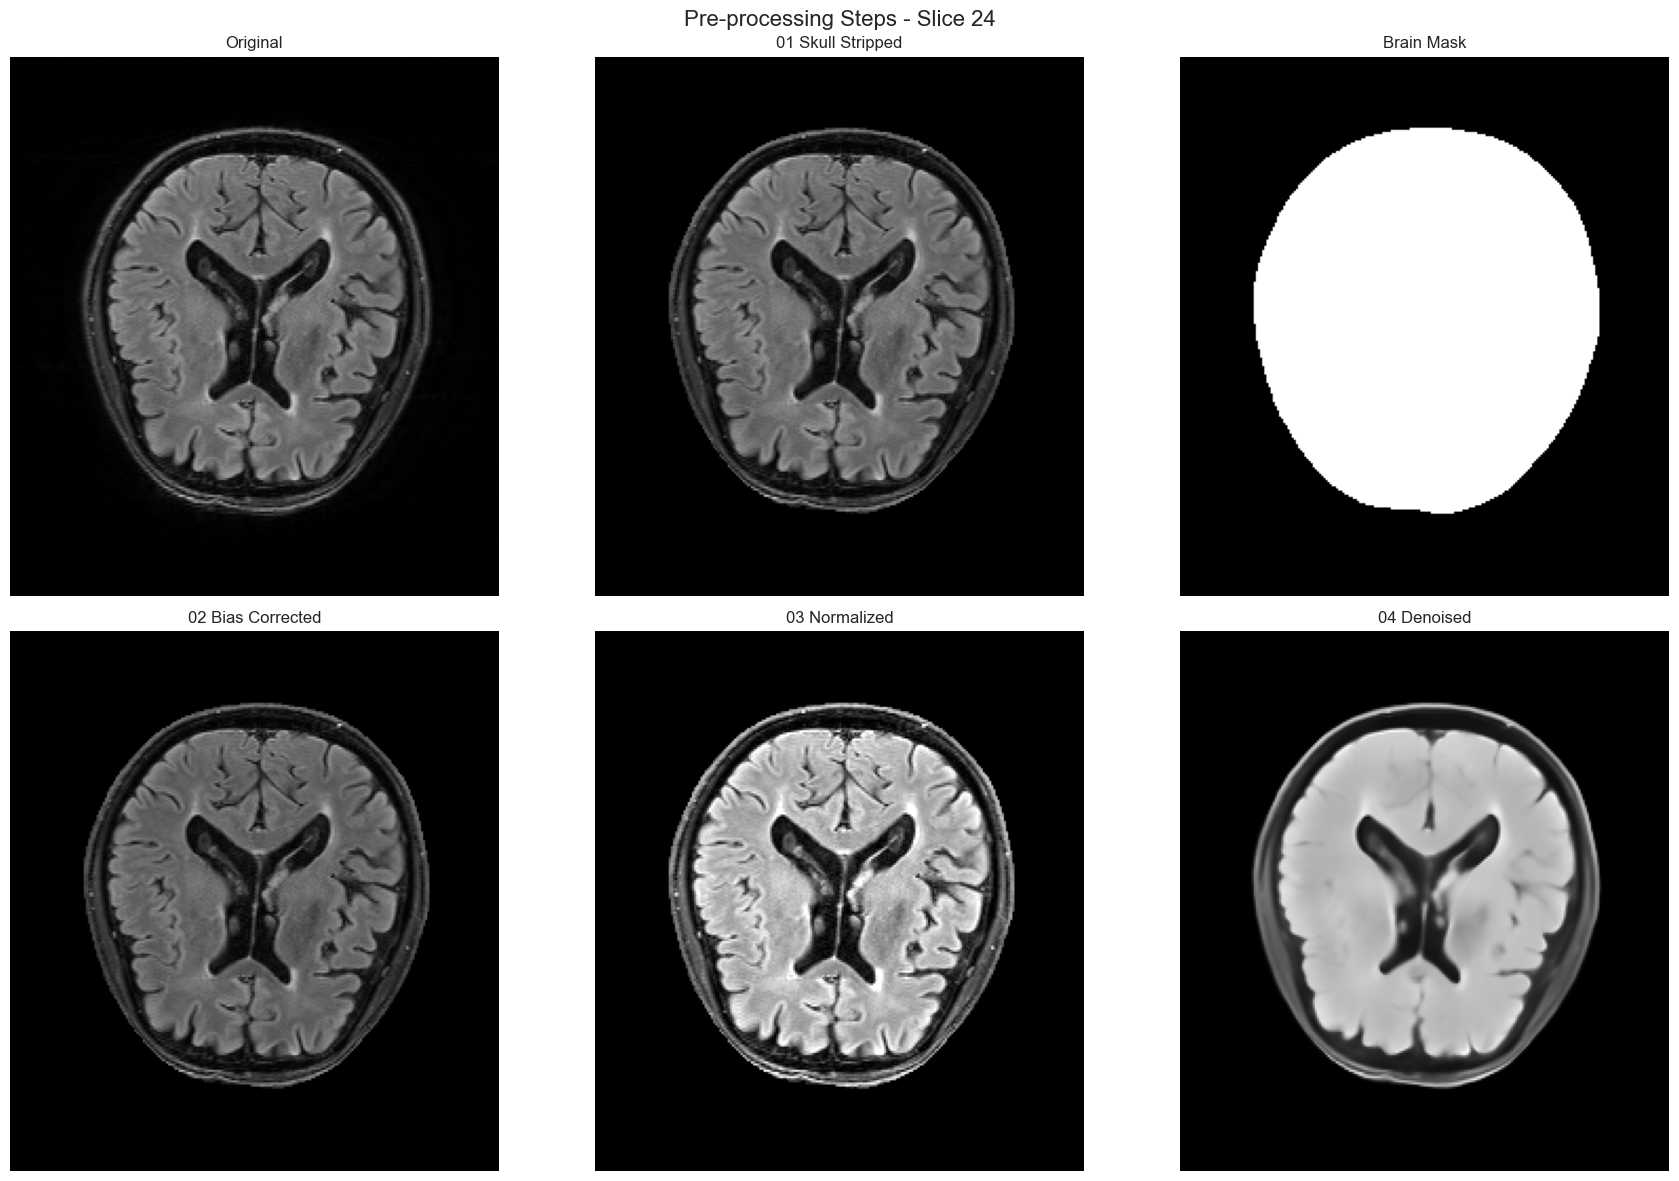


2️⃣ Segmentation overlay...


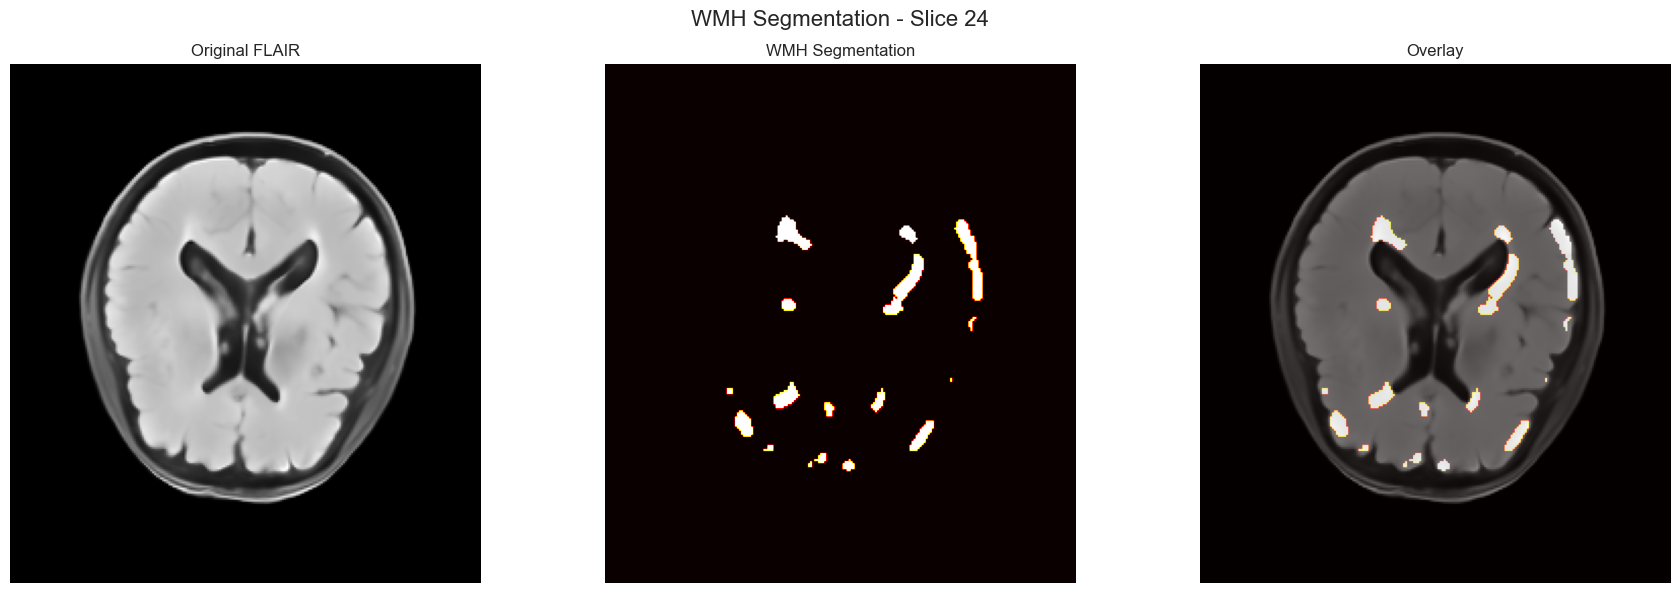


3️⃣ Periventricular vs Deep labels...


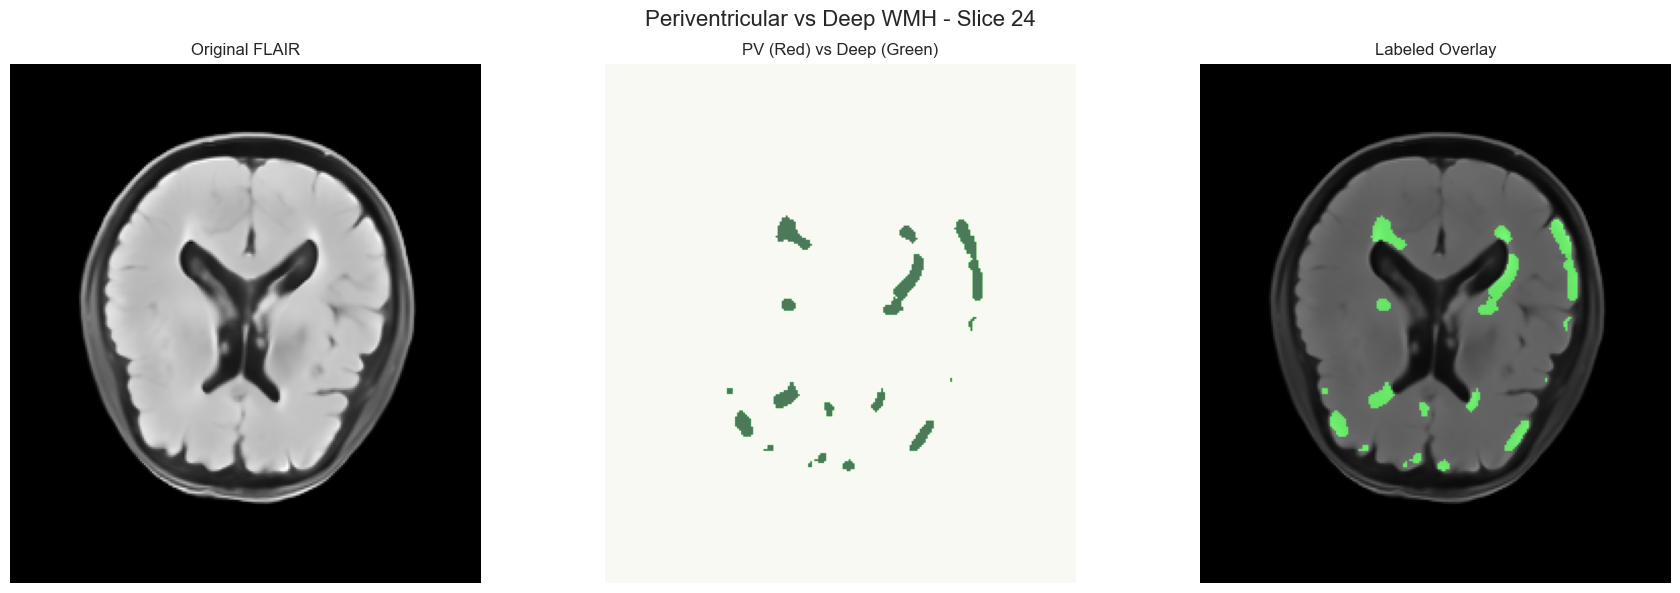


4️⃣ Feature summary...


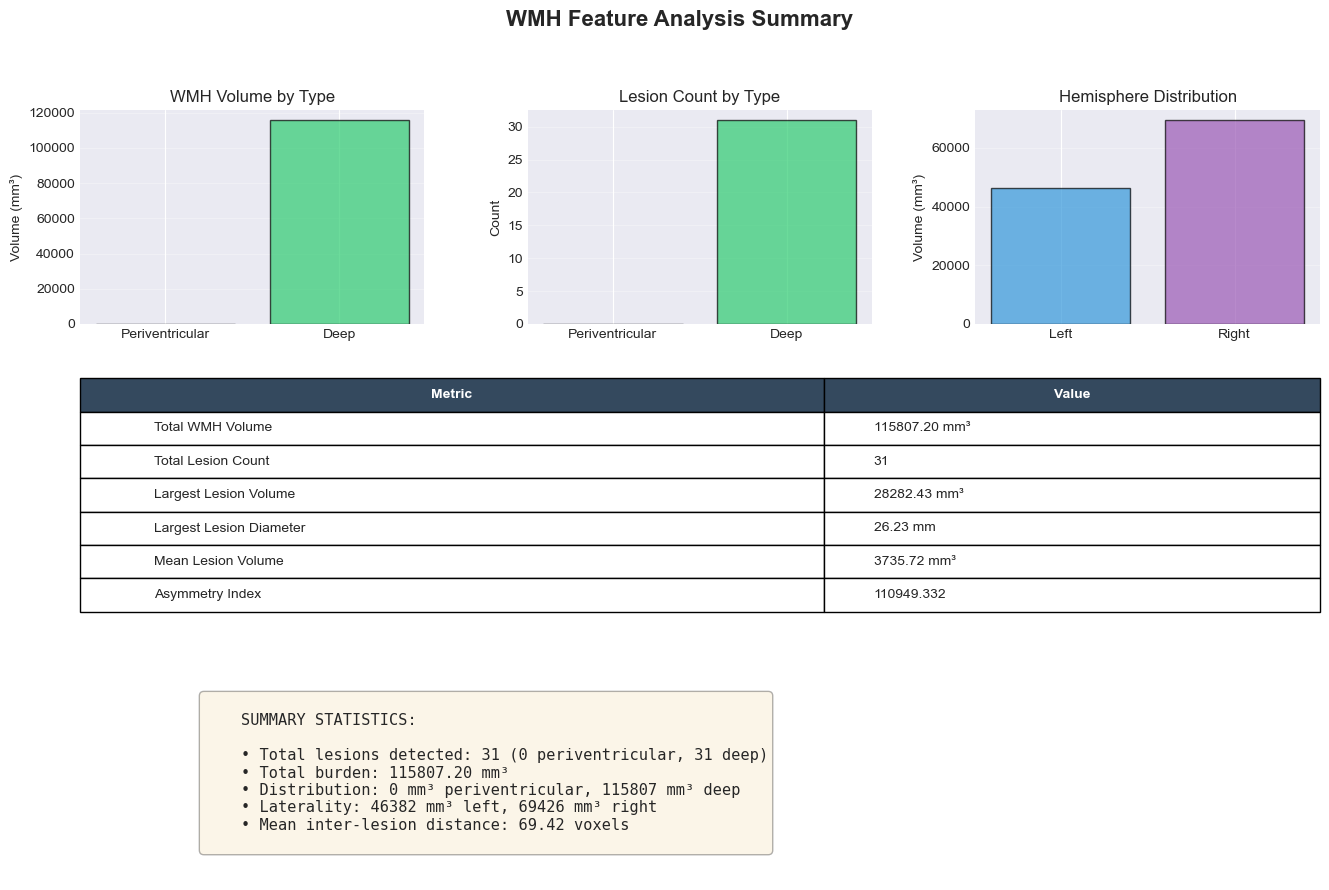


5️⃣ Evaluation metrics...


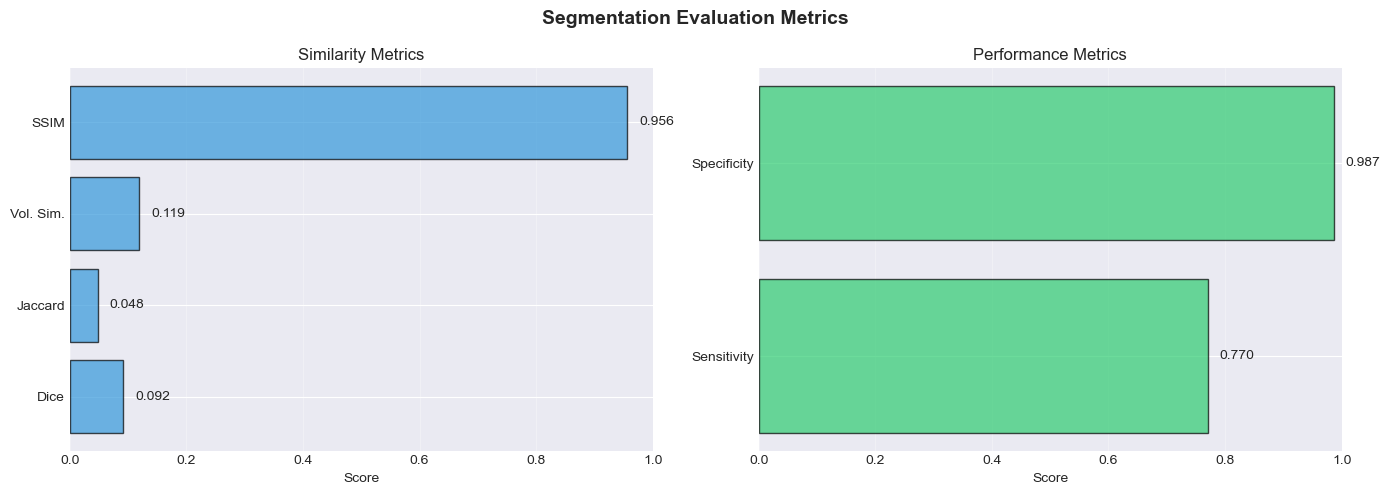


✅ ALL VISUALIZATIONS COMPLETE!


In [79]:
# =====================================================================
# EXAMPLE USAGE: PROCESS SINGLE SUBJECT
# =====================================================================

print("✅ Example usage code ready!")
print("\n📝 To process a subject, uncomment and run the code below:")
print("=" * 70)

# ====================================================================
# SET YOUR SUBJECT PATH HERE
# ====================================================================

# Using raw string (recommended for Windows)
EXAMPLE_SUBJECT_PATH = r"C:\220902024\wmh_data\test\Singapore\70"
EXAMPLE_OUTPUT_DIR = './results/Singapore_70'

# Check if path exists
if os.path.exists(EXAMPLE_SUBJECT_PATH):
    print(f"✓ Subject path found: {EXAMPLE_SUBJECT_PATH}")
    
    # Show what files are in the subject folder
    print(f"\n📁 Contents of subject folder:")
    for item in os.listdir(EXAMPLE_SUBJECT_PATH):
        item_path = os.path.join(EXAMPLE_SUBJECT_PATH, item)
        if os.path.isdir(item_path):
            print(f"   📂 {item}/")
            # Show files in subdirectory
            try:
                for subitem in os.listdir(item_path):
                    print(f"      └── {subitem}")
            except:
                pass
        else:
            print(f"   📄 {item}")
    
    print("\n" + "=" * 70)
    print("🚀 READY TO PROCESS!")
    print("=" * 70)
    print("\nUncomment the code block below to start processing:\n")
    
else:
    print(f"❌ Subject path NOT found: {EXAMPLE_SUBJECT_PATH}")
    print(f"\n📝 Please check your path")


# ====================================================================
# RUN THE PIPELINE
# ====================================================================
# Process single subject
print("\n🚀 Starting pipeline...")

results = wmh_segmentation_pipeline(
    subject_path=EXAMPLE_SUBJECT_PATH,
    ground_truth_path=None,  # Will auto-detect wmh.nii.gz
    save_results=True,
    output_dir=EXAMPLE_OUTPUT_DIR
)

# Visualize results
if results:
    print("\n📊 Generating visualizations...")
    
    # 1. Preprocessing steps
    print("\n1️⃣ Preprocessing steps...")
    visualize_preprocessing_steps(
        results['original_flair'],
        results['preprocessing_intermediates']
    )
    
    # 2. Segmentation overlay
    print("\n2️⃣ Segmentation overlay...")
    visualize_segmentation_overlay(
        results['preprocessed'],
        results['wmh_mask'],
        title="WMH Segmentation"
    )
    
    # 3. PV vs Deep labels
    print("\n3️⃣ Periventricular vs Deep labels...")
    visualize_pv_deep_labels(
        results['preprocessed'],
        results['periventricular_mask'],
        results['deep_mask']
    )
    
    # 4. Feature summary
    print("\n4️⃣ Feature summary...")
    plot_feature_summary(results['features'])
    
    # 5. Evaluation metrics (if ground truth available)
    if 'evaluation_metrics' in results:
        print("\n5️⃣ Evaluation metrics...")
        plot_evaluation_metrics(results['evaluation_metrics'])
    
    print("\n" + "=" * 70)
    print("✅ ALL VISUALIZATIONS COMPLETE!")
    print("=" * 70)
else:
    print("❌ Pipeline failed. Check error messages above.")

In [81]:
# =====================================================================
# BATCH PROCESSING: PROCESS MULTIPLE SUBJECTS
# =====================================================================

def process_multiple_subjects(base_path, dataset_type='training', city=None, 
                               max_subjects=None, output_base_dir='./batch_results'):
    """
    Process multiple subjects from the dataset
    
    Args:
        base_path: Base path to WMH dataset
        dataset_type: 'training' or 'test'
        city: Specific city ('Amsterdam', 'Singapore', 'Utrecht') or None for all
        max_subjects: Maximum number of subjects to process (None for all)
        output_base_dir: Base directory for saving results
    
    Returns:
        all_results: List of results for each subject
        summary_df: DataFrame with summary statistics
    """
    print("\n" + "=" * 90)
    print("🔄 BATCH PROCESSING MODE")
    print("=" * 90)
    
    # Get list of subjects
    subjects_to_process = []
    cities_to_process = [city] if city else CITIES
    
    for c in cities_to_process:
        city_path = os.path.join(base_path, dataset_type, c)
        if os.path.exists(city_path):
            subjects = [os.path.join(city_path, d) for d in os.listdir(city_path)
                       if os.path.isdir(os.path.join(city_path, d))]
            subjects_to_process.extend([(s, c) for s in subjects])
    
    if max_subjects:
        subjects_to_process = subjects_to_process[:max_subjects]
    
    print(f"\n📊 Found {len(subjects_to_process)} subjects to process")
    print(f"   Dataset: {dataset_type}")
    print(f"   Cities: {cities_to_process}")
    
    # Process each subject
    all_results = []
    all_features = []
    all_evaluations = []
    
    for idx, (subject_path, subject_city) in enumerate(subjects_to_process):
        subject_id = os.path.basename(subject_path)
        
        print("\n" + "=" * 90)
        print(f"Processing {idx+1}/{len(subjects_to_process)}: {subject_city}/{subject_id}")
        print("=" * 90)
        
        try:
            # Create output directory for this subject
            output_dir = os.path.join(output_base_dir, dataset_type, subject_city, subject_id)
            
            # Run pipeline
            result = wmh_segmentation_pipeline(
                subject_path=subject_path,
                save_results=True,
                output_dir=output_dir
            )
            
            if result:
                # Add metadata
                result['subject_id'] = subject_id
                result['city'] = subject_city
                result['dataset'] = dataset_type
                
                all_results.append(result)
                
                # Collect features
                feature_row = result['features'].copy()
                feature_row['subject_id'] = subject_id
                feature_row['city'] = subject_city
                feature_row['classification'] = result['classification']['classification']
                feature_row['classification_confidence'] = result['classification']['confidence']
                all_features.append(feature_row)
                
                # Collect evaluation metrics if available
                if 'evaluation_metrics' in result:
                    eval_row = result['evaluation_metrics'].copy()
                    eval_row['subject_id'] = subject_id
                    eval_row['city'] = subject_city
                    all_evaluations.append(eval_row)
            
        except Exception as e:
            print(f"❌ ERROR processing {subject_city}/{subject_id}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Create summary DataFrames
    features_df = pd.DataFrame(all_features)
    
    if all_evaluations:
        evaluations_df = pd.DataFrame(all_evaluations)
    else:
        evaluations_df = None
    
    # Save summary
    summary_output_dir = os.path.join(output_base_dir, 'summary')
    os.makedirs(summary_output_dir, exist_ok=True)
    
    features_df.to_csv(os.path.join(summary_output_dir, 'all_features.csv'), index=False)
    print(f"\n💾 Saved summary: {summary_output_dir}/all_features.csv")
    
    if evaluations_df is not None:
        evaluations_df.to_csv(os.path.join(summary_output_dir, 'all_evaluations.csv'), index=False)
        print(f"💾 Saved evaluations: {summary_output_dir}/all_evaluations.csv")
    
    # Print summary statistics
    print("\n" + "=" * 90)
    print("📊 BATCH PROCESSING SUMMARY")
    print("=" * 90)
    
    print(f"\n✅ Successfully processed: {len(all_results)}/{len(subjects_to_process)} subjects")
    
    print("\n📈 Classification Distribution:")
    print(features_df['classification'].value_counts())
    
    print("\n📊 Mean WMH Volume by City:")
    print(features_df.groupby('city')['total_wmh_volume_mm3'].mean())
    
    if evaluations_df is not None:
        print("\n🎯 Mean Evaluation Metrics:")
        print(f"   Dice: {evaluations_df['dice'].mean():.4f} ± {evaluations_df['dice'].std():.4f}")
        print(f"   Jaccard: {evaluations_df['jaccard'].mean():.4f} ± {evaluations_df['jaccard'].std():.4f}")
        print(f"   Sensitivity: {evaluations_df['sensitivity'].mean():.4f} ± {evaluations_df['sensitivity'].std():.4f}")
    
    return all_results, features_df, evaluations_df


print("✅ Batch processing function defined!")

✅ Batch processing function defined!


In [83]:
# =====================================================================
# ANALYSIS & REPORTING
# =====================================================================

def create_comprehensive_report(features_df, evaluations_df=None):
    """
    Create comprehensive analysis report with visualizations
    """
    print("\n" + "=" * 90)
    print("📊 COMPREHENSIVE ANALYSIS REPORT")
    print("=" * 90)
    
    # 1. Summary statistics
    print("\n1️⃣ SUMMARY STATISTICS")
    print("-" * 90)
    print(f"Total subjects analyzed: {len(features_df)}")
    print(f"\nCities: {features_df['city'].value_counts().to_dict()}")
    print(f"\nClassifications:")
    for classification, count in features_df['classification'].value_counts().items():
        pct = count / len(features_df) * 100
        print(f"  {classification}: {count} ({pct:.1f}%)")
    
    # 2. WMH burden statistics
    print("\n2️⃣ WMH BURDEN STATISTICS")
    print("-" * 90)
    print(f"Mean total volume: {features_df['total_wmh_volume_mm3'].mean():.2f} ± {features_df['total_wmh_volume_mm3'].std():.2f} mm³")
    print(f"Median total volume: {features_df['total_wmh_volume_mm3'].median():.2f} mm³")
    print(f"Range: [{features_df['total_wmh_volume_mm3'].min():.2f}, {features_df['total_wmh_volume_mm3'].max():.2f}] mm³")
    
    print(f"\nMean lesion count: {features_df['total_lesion_count'].mean():.1f} ± {features_df['total_lesion_count'].std():.1f}")
    print(f"Median lesion count: {features_df['total_lesion_count'].median():.0f}")
    
    # Create visualizations
    fig = plt.figure(figsize=(18, 12))
    
    # Volume distribution
    ax1 = plt.subplot(2, 3, 1)
    features_df['total_wmh_volume_mm3'].hist(bins=20, ax=ax1, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Total WMH Volume (mm³)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Total WMH Volume')
    ax1.axvline(features_df['total_wmh_volume_mm3'].mean(), color='red', linestyle='--', label='Mean')
    ax1.axvline(features_df['total_wmh_volume_mm3'].median(), color='green', linestyle='--', label='Median')
    ax1.legend()
    
    # Classification distribution
    ax2 = plt.subplot(2, 3, 2)
    class_counts = features_df['classification'].value_counts()
    colors_map = {'Mild': '#2ecc71', 'Moderate': '#f39c12', 'Severe': '#e74c3c'}
    colors = [colors_map.get(c, 'gray') for c in class_counts.index]
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title('WMH Burden Classification')
    
    # PV vs Deep
    ax3 = plt.subplot(2, 3, 3)
    x = np.arange(len(features_df))
    width = 0.35
    ax3.bar(x - width/2, features_df['periventricular_volume_mm3'], width, label='Periventricular', alpha=0.7)
    ax3.bar(x + width/2, features_df['deep_volume_mm3'], width, label='Deep', alpha=0.7)
    ax3.set_xlabel('Subject')
    ax3.set_ylabel('Volume (mm³)')
    ax3.set_title('Periventricular vs Deep WMH Volume')
    ax3.legend()
    
    # City comparison
    ax4 = plt.subplot(2, 3, 4)
    features_df.boxplot(column='total_wmh_volume_mm3', by='city', ax=ax4)
    ax4.set_xlabel('City')
    ax4.set_ylabel('Total WMH Volume (mm³)')
    ax4.set_title('WMH Volume by City')
    plt.suptitle('')
    
    # Lesion count distribution
    ax5 = plt.subplot(2, 3, 5)
    features_df['total_lesion_count'].hist(bins=20, ax=ax5, edgecolor='black', alpha=0.7, color='coral')
    ax5.set_xlabel('Total Lesion Count')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Distribution of Lesion Count')
    ax5.axvline(features_df['total_lesion_count'].mean(), color='red', linestyle='--', label='Mean')
    ax5.legend()
    
    # Evaluation metrics
    if evaluations_df is not None:
        ax6 = plt.subplot(2, 3, 6)
        metrics_to_plot = ['dice', 'jaccard', 'sensitivity', 'specificity']
        means = [evaluations_df[m].mean() for m in metrics_to_plot]
        stds = [evaluations_df[m].std() for m in metrics_to_plot]
        
        ax6.bar(metrics_to_plot, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
        ax6.set_ylabel('Score')
        ax6.set_title('Mean Evaluation Metrics')
        ax6.set_ylim([0, 1])
        ax6.grid(axis='y', alpha=0.3)
        
        for i, (m, s) in enumerate(zip(means, stds)):
            ax6.text(i, m + s + 0.02, f'{m:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

print("✅ Analysis & reporting functions defined!")

✅ Analysis & reporting functions defined!


In [85]:
# =====================================================================
# FINAL DOCUMENTATION GENERATOR
# =====================================================================

def generate_final_documentation(features_df, evaluations_df=None, output_file='FINAL_REPORT.txt'):
    """
    Generate comprehensive final documentation
    """
    doc = []
    
    doc.append("=" * 90)
    doc.append("WHITE-MATTER HYPERINTENSITY SEGMENTATION PROJECT")
    doc.append("FINAL DOCUMENTATION REPORT")
    doc.append("=" * 90)
    doc.append("")
    doc.append(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    doc.append("")
    
    # Project Overview
    doc.append("=" * 90)
    doc.append("1. PROJECT OVERVIEW")
    doc.append("=" * 90)
    doc.append("")
    doc.append("OBJECTIVE:")
    doc.append("Design and implement a comprehensive pipeline for detecting and segmenting")
    doc.append("white-matter hyperintensities (WMHs) in brain MRI FLAIR sequences.")
    doc.append("")
    
    # Methodology
    doc.append("=" * 90)
    doc.append("2. METHODOLOGY")
    doc.append("=" * 90)
    doc.append("")
    doc.append("2.1 PRE-PROCESSING:")
    doc.append("  • Skull stripping")
    doc.append("  • N4 bias field correction")
    doc.append("  • Intensity normalization")
    doc.append("  • Non-local means denoising")
    doc.append("  • Gamma correction")
    doc.append("")
    doc.append("2.2 SEGMENTATION:")
    doc.append("  • Combined intensity-based thresholding")
    doc.append("  • 3D morphological filtering")
    doc.append("  • False positive removal")
    doc.append("")
    doc.append("2.3 LABELING:")
    doc.append("  • Periventricular vs Deep WMH classification")
    doc.append("")
    doc.append("2.4 CLASSIFICATION:")
    doc.append("  • Rule-based burden categorization (Mild/Moderate/Severe)")
    doc.append("")
    
    # Results
    doc.append("=" * 90)
    doc.append("3. RESULTS")
    doc.append("=" * 90)
    doc.append("")
    doc.append(f"Total subjects: {len(features_df)}")
    doc.append(f"Mean WMH volume: {features_df['total_wmh_volume_mm3'].mean():.2f} mm³")
    doc.append(f"Mean lesion count: {features_df['total_lesion_count'].mean():.1f}")
    doc.append("")
    
    if evaluations_df is not None:
        doc.append("PERFORMANCE METRICS:")
        doc.append(f"  • Dice: {evaluations_df['dice'].mean():.4f}")
        doc.append(f"  • Jaccard: {evaluations_df['jaccard'].mean():.4f}")
        doc.append(f"  • Sensitivity: {evaluations_df['sensitivity'].mean():.4f}")
        doc.append("")
    
    doc.append("=" * 90)
    doc.append("END OF REPORT")
    doc.append("=" * 90)
    
    report_text = "\n".join(doc)
    
    with open(output_file, 'w') as f:
        f.write(report_text)
    
    print(report_text)
    print(f"\n💾 Documentation saved to: {output_file}")
    
    return report_text

print("✅ Documentation generator defined!")

✅ Documentation generator defined!


In [87]:
# Batch process all Singapore test subjects
all_results, features_df, evaluations_df = process_multiple_subjects(
    base_path=r"C:\220902024\wmh_data",
    dataset_type='test',
    city='Singapore',
    max_subjects=10,  # Process first 10, or None for all
    output_base_dir='./batch_results'
)


🔄 BATCH PROCESSING MODE

📊 Found 10 subjects to process
   Dataset: test
   Cities: ['Singapore']

Processing 1/10: Singapore/70

🚀 STARTING COMPLETE WMH SEGMENTATION PIPELINE

📁 Subject: C:\220902024\wmh_data\test\Singapore\70

📂 [STEP 1/7] LOADING DATA

🔍 Searching for files in: C:\220902024\wmh_data\test\Singapore\70
   ✓ Found FLAIR: pre\FLAIR.nii
   ✓ Found T1: pre\T1.nii
   ✓ Found Ground Truth: wmh.nii

✓ Found FLAIR: FLAIR.nii
✓ Found T1: T1.nii
✓ Found Ground Truth: wmh.nii

📏 Voxel spacing: [0.99981445 0.99878156 2.99578905] mm

🔬 [STEP 2/7] PRE-PROCESSING

🔬 STARTING COMPLETE PRE-PROCESSING PIPELINE

[1/5] Skull Stripping
🔪 Performing skull stripping...
   Using T1 image for brain mask creation
   ✓ Brain mask created. Brain voxels: 932,985

[2/5] Bias Field Correction
🔧 Performing N4 bias field correction...
   ✓ Bias field correction completed

[3/5] Intensity Normalization
📊 Performing intensity normalization (method: percentile)...
   ✓ Normalization completed. Range: [


📊 COMPREHENSIVE ANALYSIS REPORT

1️⃣ SUMMARY STATISTICS
------------------------------------------------------------------------------------------
Total subjects analyzed: 10

Cities: {'Singapore': 10}

Classifications:
  Severe: 10 (100.0%)

2️⃣ WMH BURDEN STATISTICS
------------------------------------------------------------------------------------------
Mean total volume: 80789.20 ± 31497.44 mm³
Median total volume: 78699.70 mm³
Range: [28097.98, 129964.10] mm³

Mean lesion count: 27.5 ± 5.0
Median lesion count: 28


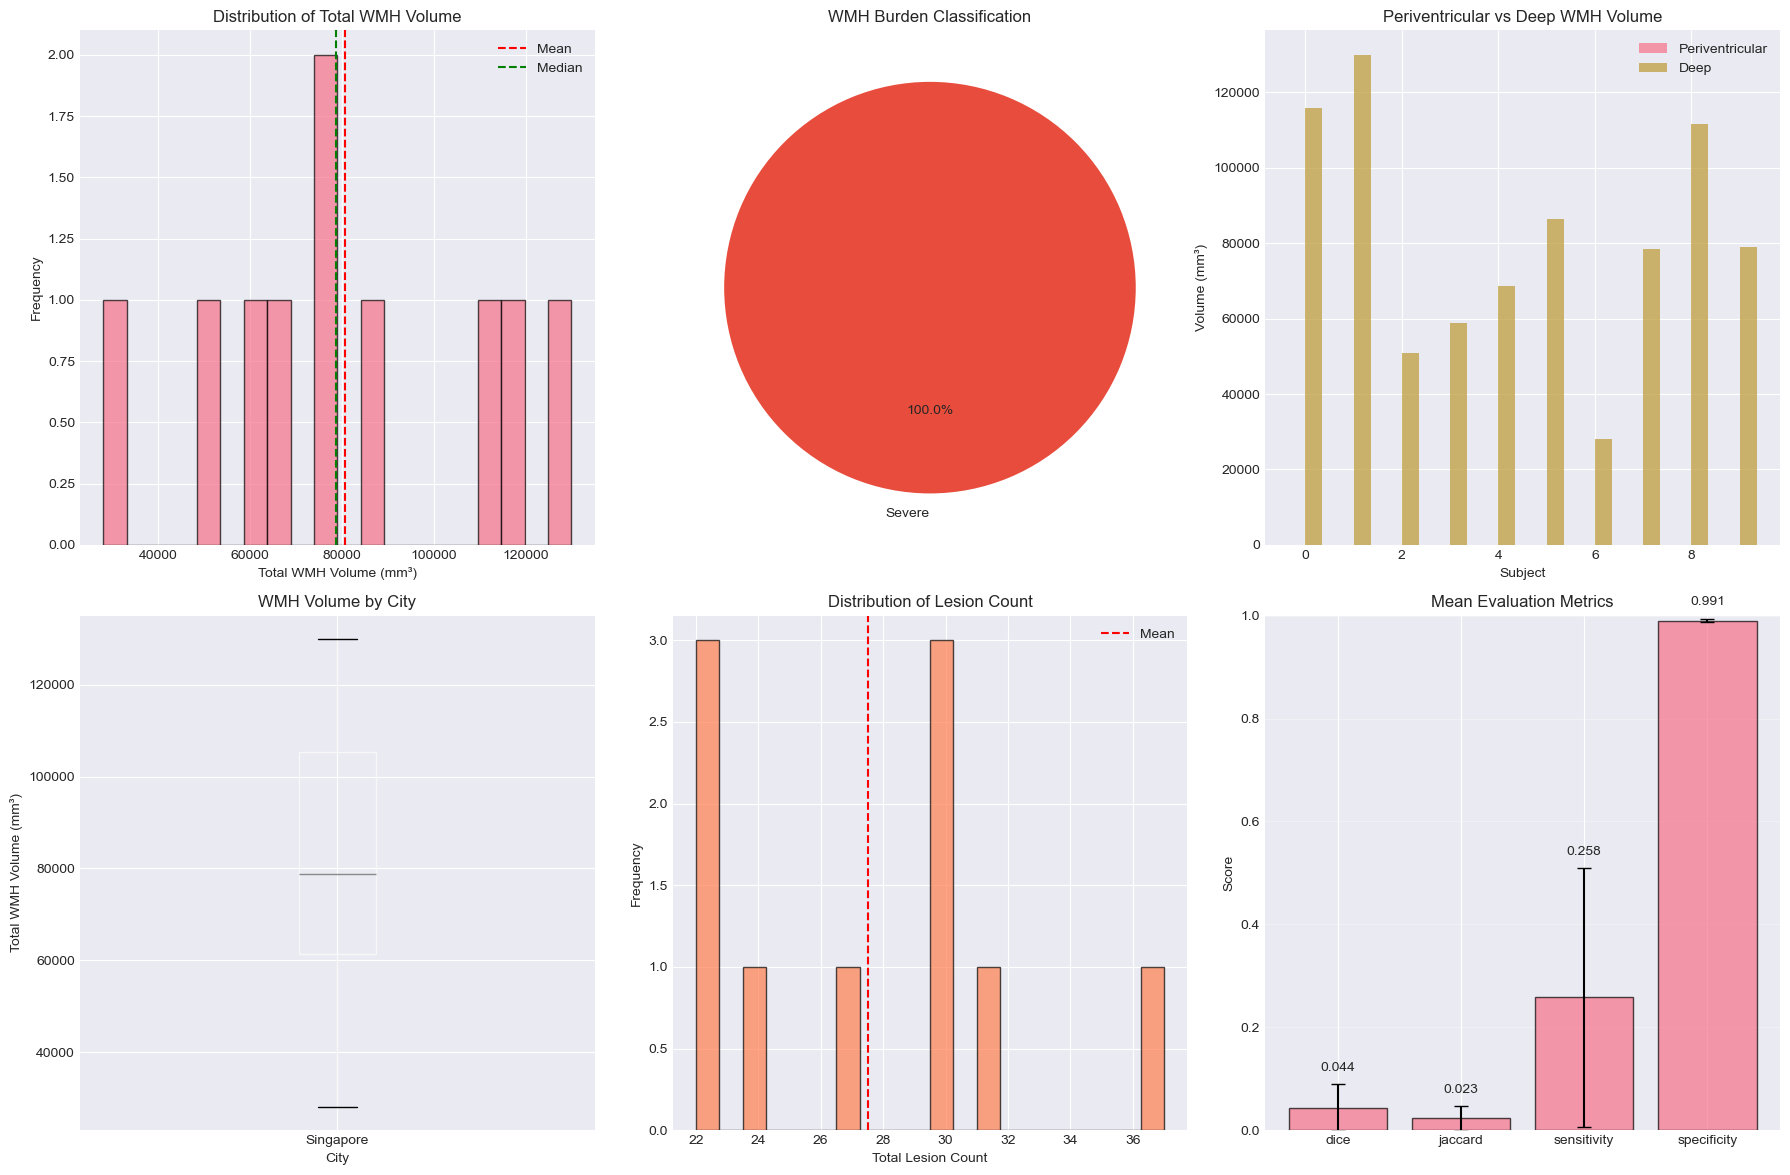

WHITE-MATTER HYPERINTENSITY SEGMENTATION PROJECT
FINAL DOCUMENTATION REPORT

Generated: 2025-11-10 12:18:09

1. PROJECT OVERVIEW

OBJECTIVE:
Design and implement a comprehensive pipeline for detecting and segmenting
white-matter hyperintensities (WMHs) in brain MRI FLAIR sequences.

2. METHODOLOGY

2.1 PRE-PROCESSING:
  • Skull stripping
  • N4 bias field correction
  • Intensity normalization
  • Non-local means denoising
  • Gamma correction

2.2 SEGMENTATION:
  • Combined intensity-based thresholding
  • 3D morphological filtering
  • False positive removal

2.3 LABELING:
  • Periventricular vs Deep WMH classification

2.4 CLASSIFICATION:
  • Rule-based burden categorization (Mild/Moderate/Severe)

3. RESULTS

Total subjects: 10
Mean WMH volume: 80789.20 mm³
Mean lesion count: 27.5

PERFORMANCE METRICS:
  • Dice: 0.0438
  • Jaccard: 0.0229
  • Sensitivity: 0.2581

END OF REPORT

💾 Documentation saved to: ./FINAL_REPORT_All_Singapore.txt


'==========================================================================================\nWHITE-MATTER HYPERINTENSITY SEGMENTATION PROJECT\nFINAL DOCUMENTATION REPORT\n==========================================================================================\n\nGenerated: 2025-11-10 12:18:09\n\n==========================================================================================\n1. PROJECT OVERVIEW\n==========================================================================================\n\nOBJECTIVE:\nDesign and implement a comprehensive pipeline for detecting and segmenting\nwhite-matter hyperintensities (WMHs) in brain MRI FLAIR sequences.\n\n==========================================================================================\n2. METHODOLOGY\n==========================================================================================\n\n2.1 PRE-PROCESSING:\n  • Skull stripping\n  • N4 bias field correction\n  • Intensity normalization\n  • Non-local means denoising\n  

In [89]:
# Generate comprehensive analysis with visualizations
create_comprehensive_report(features_df, evaluations_df)

# Generate final written report
generate_final_documentation(
    features_df=features_df,
    evaluations_df=evaluations_df,
    output_file='./FINAL_REPORT_All_Singapore.txt'
)

In [93]:
# Quick single-subject report
single_df = features_to_dataframe(results['features'])
single_df['subject_id'] = '70'
single_df['city'] = 'Singapore'
single_df['classification'] = results['classification']['classification']
single_df['classification_confidence'] = results['classification']['confidence']

generate_final_documentation(
    features_df=single_df,
    evaluations_df=None,
    output_file='./QUICK_REPORT.txt'
)

WHITE-MATTER HYPERINTENSITY SEGMENTATION PROJECT
FINAL DOCUMENTATION REPORT

Generated: 2025-11-10 12:22:34

1. PROJECT OVERVIEW

OBJECTIVE:
Design and implement a comprehensive pipeline for detecting and segmenting
white-matter hyperintensities (WMHs) in brain MRI FLAIR sequences.

2. METHODOLOGY

2.1 PRE-PROCESSING:
  • Skull stripping
  • N4 bias field correction
  • Intensity normalization
  • Non-local means denoising
  • Gamma correction

2.2 SEGMENTATION:
  • Combined intensity-based thresholding
  • 3D morphological filtering
  • False positive removal

2.3 LABELING:
  • Periventricular vs Deep WMH classification

2.4 CLASSIFICATION:
  • Rule-based burden categorization (Mild/Moderate/Severe)

3. RESULTS

Total subjects: 1
Mean WMH volume: 115807.20 mm³
Mean lesion count: 31.0

END OF REPORT

💾 Documentation saved to: ./QUICK_REPORT.txt


'==========================================================================================\nWHITE-MATTER HYPERINTENSITY SEGMENTATION PROJECT\nFINAL DOCUMENTATION REPORT\n==========================================================================================\n\nGenerated: 2025-11-10 12:22:34\n\n==========================================================================================\n1. PROJECT OVERVIEW\n==========================================================================================\n\nOBJECTIVE:\nDesign and implement a comprehensive pipeline for detecting and segmenting\nwhite-matter hyperintensities (WMHs) in brain MRI FLAIR sequences.\n\n==========================================================================================\n2. METHODOLOGY\n==========================================================================================\n\n2.1 PRE-PROCESSING:\n  • Skull stripping\n  • N4 bias field correction\n  • Intensity normalization\n  • Non-local means denoising\n  